In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emcee as mc
import corner
import time
from matplotlib import style
style.use('dark_background')
plt.rc('lines',linewidth=2)
%matplotlib inline

# Castle Invasion via Markov Chain Monte Carlo
Problem: Find the best possible deployment of our 100 soldiers to the 10 ranked castles such that we win the maximum number of battles, given the previous war's data.  The number of ways to send 100 soldiers to 10 castles is extremely large, far too large to try all of them.  Also, my opponents also have this information, so the deployment must be robust to new, unexpected strategies.

Idea: Sample the large state space of potential deployments via a Markov Chain Monte Carlo (MCMC).  The MCMC allows ~100 "walkers" to walk in the state space of potential deployments, calculate the reward for its current deployment, and use its current reward to decide whether to move to another state or stay where it is.  All of the above is hidden in the "emcee" package by Dan Foreman-Mackey (http://dan.iel.fm/emcee/current/).  Most of my code is simplying setting up this MCMC algorithm for greatness.

### Couple of issues with this approach:
Our state space of deployments is discrete, but emcee is a continuous-space sampler.  I just round my results, and make sure that sum(deployment) == 100.  

This approach also takes a long time, most likely stemming from the fact that calculating the reward for any deployment takes 0.015 seconds, and we have to do this number_samples = number_walkers * number_steps times (this ends up being ~100 * 1000 * 0.015 seconds = 1500 seconds).


In [2]:
# Initialize a state space for soldiers in castles
testDeployment = 10*np.ones(10, dtype=int)

In [4]:
# Load castle deployment data
castleInvasionData = np.loadtxt(open("./castle-solutions.csv", "rb"), \
                                delimiter=",", skiprows=1, usecols=(range(10)), dtype=int)
print castleInvasionData[300]
print np.shape(castleInvasionData)

[ 3  5  7  9 11 13 15 17 19  1]
(1387, 10)


In [94]:
# Function which takes in a deployment of floats, which are output by the MCMC results, rounds them to the nearest int, and 
# then adds or subtracts soldiers from castles to ensure there are only 100
def normalizer(floatDeployment):
    deployment = np.rint( floatDeployment ).astype(int) # Round the result to nearest int
    
    # Ensure there are only 100 soldiers deployed, since rounding can yield more or less than 100 soldiers
    if np.sum(deployment) > 100:         # If number of soldiers is more than 100
        while np.sum(deployment) > 100:       # While this is true
            diff = floatDeployment - deployment   # Find the difference between the int and float distributions
            index = np.argmin(diff)               # Find where the difference is the smallest (most negative)
            deployment[index] += -1               # Subtract a soldier from that castle
    if np.sum(deployment) < 100:
        while np.sum(deployment) < 100:
            diff = floatDeployment - deployment
            index = np.argmax(diff)
            deployment[index] += 1
    return deployment

In [92]:
# Function which takes in two deployments and checks who wins.  It assumes the deployments are legal.
def battler(deployment1, deployment2):
    scoreVector = np.arange(1, 11)      # Score for each battle victory (1 through 10, with Castle 10 being the most valuable)
    totalScore = np.sum(scoreVector)    # Total points available is 55
    halfScoreVector = scoreVector / 2.0 # Half score vector for ties
    
    playerWinsCastle  = deployment1 > deployment2   # Make boolean vector for wins, ties, and losses
    playerTiesCastle  = deployment1 == deployment2  
    playerLosesCastle = deployment1 < deployment2

    playerScore = np.sum( playerWinsCastle * scoreVector + playerTiesCastle * halfScoreVector )    # Calculate this battle's score
    opponentScore = np.sum( playerLosesCastle * scoreVector + playerTiesCastle * halfScoreVector )
    if playerScore > opponentScore:   # If the player wins the war
        winner = 1                    # Return 1
    elif playerScore < opponentScore: # If the player loses the war
        winner = -1                   # Return -1
    else:                             # If tie
        winner = 0                    # Return nothing
            
    return winner, playerScore, opponentScore

In [4]:
# Calculate the reward for your deployment.  This function assumes the deployment you've entered is legal.
def calcReward(curDeployment):
    totalReward = 0
    totalWins = 0    
    totalTies = 0
    
    scoreVector = np.arange(1, 11)      # Score for each battle victory (1 through 10, with Castle 10 being the most valuable)
    totalScore = np.sum(scoreVector)    # Total points available is 55
    halfScoreVector = scoreVector / 2.0 # Half score vector for ties
    
    for opponentDeployment in castleInvasionData: # For each opponent in the dataset
        playerWinsCastle  = curDeployment > opponentDeployment   # Make boolean vector for wins, ties, and losses
        playerTiesCastle  = curDeployment == opponentDeployment  
        playerLosesCastle = curDeployment < opponentDeployment

        playerScore = np.sum( playerWinsCastle * scoreVector + playerTiesCastle * halfScoreVector )    # Calculate this battle's score
        opponentScore = np.sum( playerLosesCastle * scoreVector + playerTiesCastle * halfScoreVector )
        if playerScore > opponentScore:   # If the player wins the war
            totalReward += 1              # Add to the total reward, wins
            totalWins += 1
        elif playerScore < opponentScore: # If the player loses the war
            totalReward += -1             # Subtract from the total reward
        else:
            totalTies += 1
            
    return totalReward, totalWins, totalTies

In [5]:
# Define a log likelihood to maximize based on our walkers sampling the state space
def lnprob(floatDeployment):
    curDeployment = np.rint(floatDeployment).astype(int) # transform the deployment into ints
    if np.any(curDeployment < 0) or np.sum(curDeployment) > 100: # if deployment is illegal
        return -np.inf
    else :
        reward, wins, ties = calcReward(curDeployment)
        return wins + 1.0 # return number of wins plus half the number of ties, which is always positive,

In [6]:
# Define number of dimensions, number of walkers, and randomize the state space inputs p0
ndim = 10
nwalkers = 100
rr = np.transpose(np.vstack([np.random.normal(-0.5, 1.0, nwalkers), np.random.normal(-0.5, 1.0, nwalkers),
                             np.random.normal(-0.5, 1.0, nwalkers), np.random.normal(-0.5, 1.0, nwalkers),
                             np.random.normal(-0.5, 1.0, nwalkers), np.random.normal(-0.5, 1.0, nwalkers),
                             np.random.normal(-0.5, 1.0, nwalkers), np.random.normal(-0.5, 1.0, nwalkers),
                             np.random.normal(-0.5, 1.0, nwalkers), np.random.normal(-0.5, 1.0, nwalkers) ]))
p0 = np.tile(testDeployment, (nwalkers,1)) + rr
print p0[0]
print np.rint(p0[0]).astype(int)

[ 10.56951259  10.78439771   9.82270231  10.32057183   9.33032119
   8.84409823   9.78761472   7.75472024  10.18357544  10.06271034]
[11 11 10 10  9  9 10  8 10 10]


In [7]:
# initialize sampler with the number of walkers, number of dimensions, and the log likelihood function lnprob
samp = mc.EnsembleSampler(nwalkers, ndim, lnprob)

In [8]:
# Run a burn-in, then throw away the older samples.  
# This prevents our MCMC from falsely reporting the posteriors around p0 from being too high.
pos, prob, state = samp.run_mcmc(p0, 100)
samp.reset()

/Library/Python/2.7/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Library/Python/2.7/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


In [9]:
start_time = time.time()
samp.run_mcmc(pos, 700);
results = np.copy(samp.flatchain) 
print 'MCMC took ', time.time() - start_time, ' seconds to finish'

MCMC took  991.688291073  seconds to finish


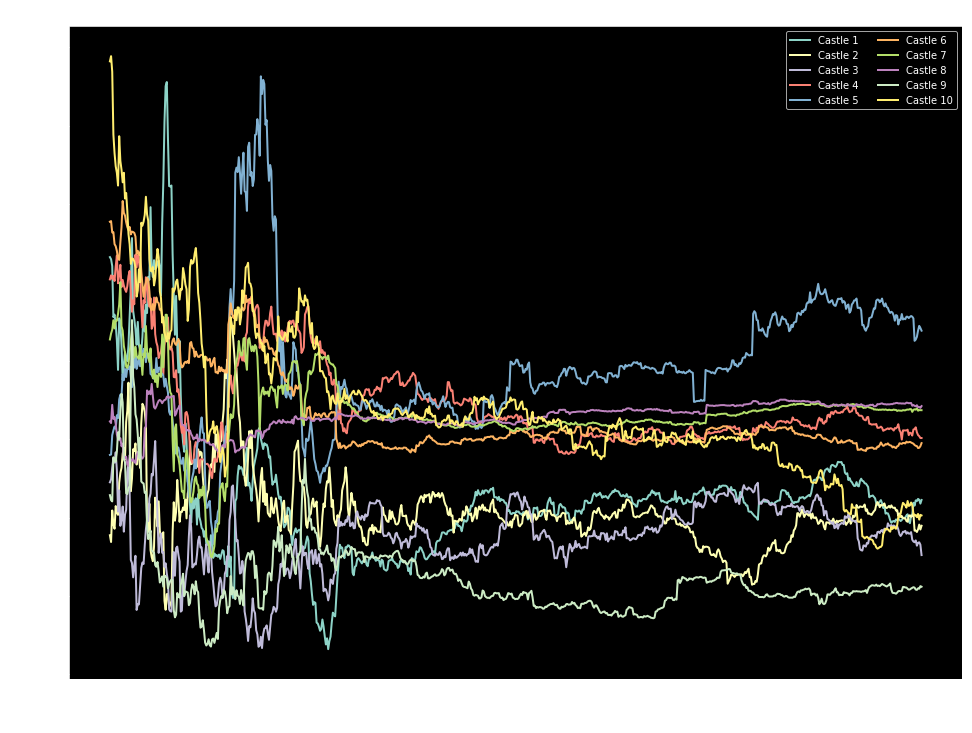

In [52]:
autocorr = mc.autocorr.integrated_time(samp.chain)
_, nn = np.shape(autocorr)
plt.figure(figsize=(16,12))
for ii in range(nn):
    plt.plot(autocorr[:,ii], label='Castle '+str(ii+1))
plt.xlabel('Sample Number', fontsize=18)
plt.title('Autocorrelation', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(ncol=2)
plt.show()

In [187]:
samp.flatlnprobability

array([  810.,   810.,   810., ...,  1206.,  1206.,  1206.])

In [11]:
# Find the most successful MCMC sample (i.e. the deployment with the most wins)
# You don't have to do this... I only just realized the number of wins is stored for you by the MCMC in samp.flatlnprobability
# That's good, because this code is very time-consuming.  
# You do have to do this if you want the number of ties and actual score

start_time2 = time.time()
maxWins = 0
maxTies = 0
maxIndex = 0
bestDeployment = np.zeros(10, dtype=int)
allWins = np.zeros( len(results) )
allTies = np.zeros( len(results) )

print np.shape(results)

for ii, floatDeployment in enumerate(results) :
#     print '1: ', time.time() - start_time2
    if np.mod(ii, 100) == 0:
        print ii, 'Time so far: ', (time.time() - start_time2) / 60., ' minutes'
    
    deployment = normalizer( floatDeployment )
    
    reward, wins, ties = calcReward(deployment)  # This is the rate limiting step, since you have to do ~1300 * 10 comparisons
    allWins[ii] = wins
    allTies[ii] = ties
#     print '4: ', time.time() - start_time2
    if wins > maxWins:
        maxIndex = ii
        maxWins = wins
        maxTies = ties
        bestDeployment = np.copy(deployment)
#     print '5: ', time.time() - start_time2
print
print '^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^'
print
print 'Best Iteration = ', maxIndex
print 'Max Wins = ', maxWins
print 'Max Ties = ', maxTies
print 'Best Deployment = ', bestDeployment
print
print 'Best Results found in ', time.time() - start_time2, ' seconds'

(70000, 10)
0 Time so far:  2.05516815186e-05  minutes
100 Time so far:  0.0324268182119  minutes
200 Time so far:  0.065064183871  minutes
300 Time so far:  0.0968763828278  minutes
400 Time so far:  0.130715902646  minutes
500 Time so far:  0.163269150257  minutes
600 Time so far:  0.195436167717  minutes
700 Time so far:  0.227550586065  minutes
800 Time so far:  0.25969581604  minutes
900 Time so far:  0.292021099726  minutes
1000 Time so far:  0.324317566554  minutes
1100 Time so far:  0.356784466902  minutes
1200 Time so far:  0.388894550006  minutes
1300 Time so far:  0.421171001593  minutes
1400 Time so far:  0.452962068717  minutes
1500 Time so far:  0.485519019763  minutes
1600 Time so far:  0.517861266931  minutes
1700 Time so far:  0.549991349379  minutes
1800 Time so far:  0.582167450587  minutes
1900 Time so far:  0.61405864954  minutes
2000 Time so far:  0.64643936952  minutes
2100 Time so far:  0.67876060009  minutes
2200 Time so far:  0.710935767492  minutes
2300 Time 

19300 Time so far:  6.20172580083  minutes
19400 Time so far:  6.23368166685  minutes
19500 Time so far:  6.26599980195  minutes
19600 Time so far:  6.29849580129  minutes
19700 Time so far:  6.33084930182  minutes
19800 Time so far:  6.36247806946  minutes
19900 Time so far:  6.39480059942  minutes
20000 Time so far:  6.42736676931  minutes
20100 Time so far:  6.4592113018  minutes
20200 Time so far:  6.49130145311  minutes
20300 Time so far:  6.52349981864  minutes
20400 Time so far:  6.55574624936  minutes
20500 Time so far:  6.58713216782  minutes
20600 Time so far:  6.61997753382  minutes
20700 Time so far:  6.6522998174  minutes
20800 Time so far:  6.68459595044  minutes
20900 Time so far:  6.71622803609  minutes
21000 Time so far:  6.74782185157  minutes
21100 Time so far:  6.77948311965  minutes
21200 Time so far:  6.81141478618  minutes
21300 Time so far:  6.84376126925  minutes
21400 Time so far:  6.87909686963  minutes
21500 Time so far:  6.91105108261  minutes
21600 Time so

38500 Time so far:  12.377900819  minutes
38600 Time so far:  12.410068651  minutes
38700 Time so far:  12.4420056661  minutes
38800 Time so far:  12.4736702005  minutes
38900 Time so far:  12.5058138013  minutes
39000 Time so far:  12.5373873353  minutes
39100 Time so far:  12.5694164673  minutes
39200 Time so far:  12.6012279352  minutes
39300 Time so far:  12.6334167163  minutes
39400 Time so far:  12.6656544844  minutes
39500 Time so far:  12.6980386694  minutes
39600 Time so far:  12.7301621159  minutes
39700 Time so far:  12.7621251861  minutes
39800 Time so far:  12.7943801165  minutes
39900 Time so far:  12.8264251351  minutes
40000 Time so far:  12.8585149169  minutes
40100 Time so far:  12.8907022993  minutes
40200 Time so far:  12.9227923354  minutes
40300 Time so far:  12.9548148831  minutes
40400 Time so far:  12.9869517684  minutes
40500 Time so far:  13.0192169189  minutes
40600 Time so far:  13.0512064854  minutes
40700 Time so far:  13.0836443861  minutes
40800 Time so

57700 Time so far:  18.5548591693  minutes
57800 Time so far:  18.5870291511  minutes
57900 Time so far:  18.6187893351  minutes
58000 Time so far:  18.6515557329  minutes
58100 Time so far:  18.6843253334  minutes
58200 Time so far:  18.7165424863  minutes
58300 Time so far:  18.7482277195  minutes
58400 Time so far:  18.7802485506  minutes
58500 Time so far:  18.8117189328  minutes
58600 Time so far:  18.8435308178  minutes
58700 Time so far:  18.8751266162  minutes
58800 Time so far:  18.9069211841  minutes
58900 Time so far:  18.9391943494  minutes
59000 Time so far:  18.9714026173  minutes
59100 Time so far:  19.0031646689  minutes
59200 Time so far:  19.0354609847  minutes
59300 Time so far:  19.0673351526  minutes
59400 Time so far:  19.0991439184  minutes
59500 Time so far:  19.1310460528  minutes
59600 Time so far:  19.1628453175  minutes
59700 Time so far:  19.1951103687  minutes
59800 Time so far:  19.2268439333  minutes
59900 Time so far:  19.2595112522  minutes
60000 Time 

Quantiles:
[(0.16, 4.660989406915979), (0.5, 5.8792024655577126), (0.84, 6.6525699883224352)]
Quantiles:
[(0.16, 5.7317181557976209), (0.5, 6.6164734892377917), (0.84, 8.6131014200429128)]
Quantiles:
[(0.16, 7.5108766153196225), (0.5, 8.2067995349411227), (0.84, 11.032468707395743)]
Quantiles:
[(0.16, 8.5136850611268908), (0.5, 8.9900106303203344), (0.84, 14.459058375705597)]
Quantiles:
[(0.16, 6.9718319993491864), (0.5, 12.150470003583115), (0.84, 13.398747842418102)]
Quantiles:
[(0.16, 9.820952541649806), (0.5, 21.625123936670366), (0.84, 22.57430967589492)]
Quantiles:
[(0.16, 3.3983785682628671), (0.5, 25.677064468690869), (0.84, 26.408376228571001)]
Quantiles:
[(0.16, 1.2411980452371632), (0.5, 1.9772570914086969), (0.84, 8.8120070367115808)]
Quantiles:
[(0.16, 3.2439496621417234), (0.5, 4.0767728680186295), (0.84, 5.9043408820042549)]
Quantiles:
[(0.16, 3.6809724321549706), (0.5, 4.4648716587214263), (0.84, 6.7700259624310437)]


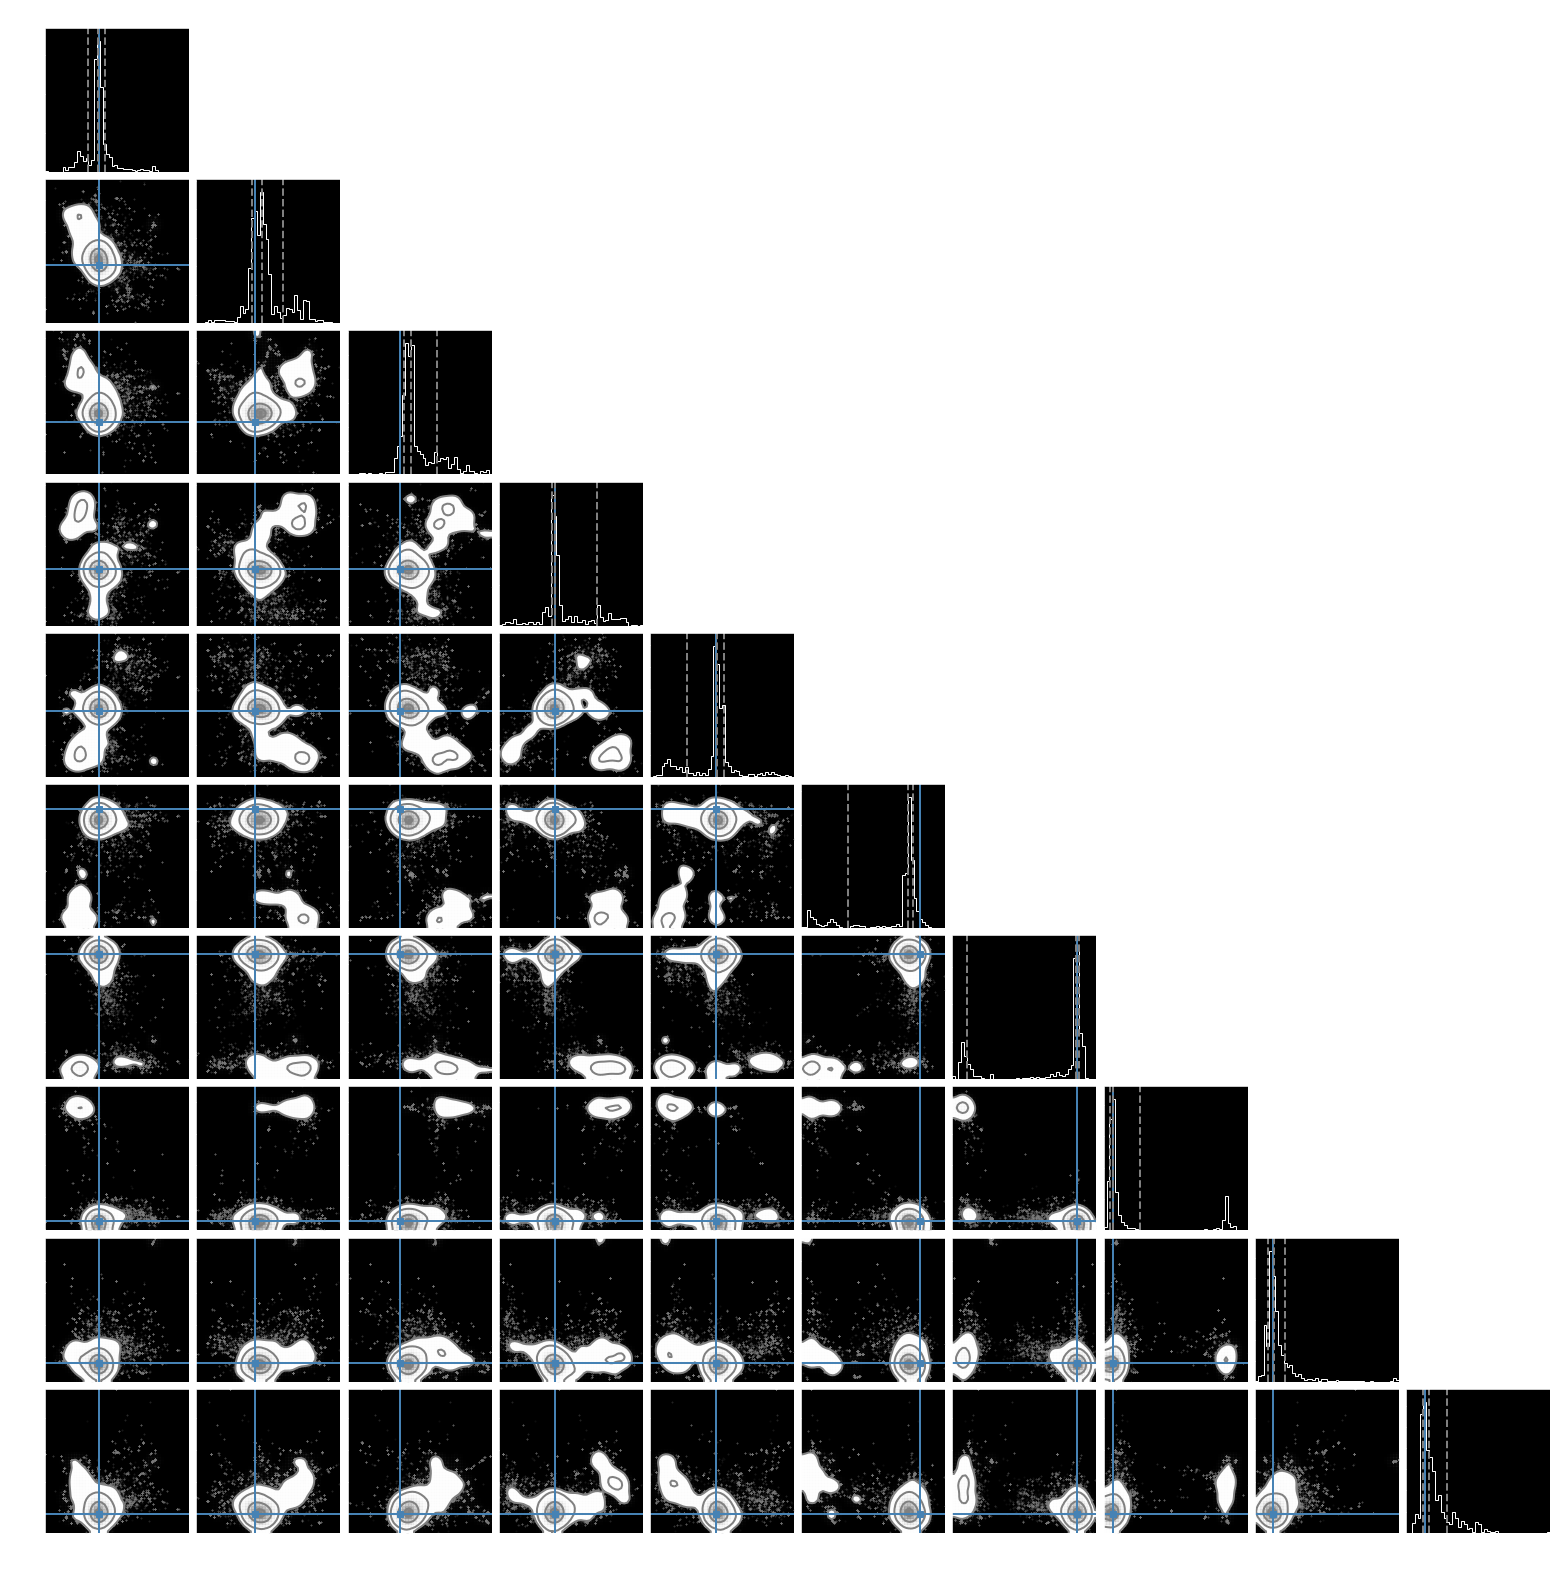

In [236]:
# Using the convenient "corner" python package, create cornerplots representing the sample deployments at each castle.
# Corner python package: (http://corner.readthedocs.io/en/latest/)
# The blue lines are the "truths", or the best deployment found by the MCMC
h_c = corner.corner(results, 
                    color='0.5',
                    bins=50, 
                    labels=['Castle 1', 'Castle 2', 'Castle 3', 'Castle 4', 'Castle 5', \
                            'Castle 6', 'Castle 7', 'Castle 8', 'Castle 9', 'Castle 10'],
                    show_titles=True,
                    title_kwargs={'fontsize':14},
                    label_kwargs={'fontsize':16},
                    quantiles=[0.16, 0.5, 0.84],
                    truths=bestDeployment,
                    smooth=2,
                    verbose=True,
                    hist_kwargs={'color':'w'})
h_c.savefig('./MCMC_CastleDeploymentCornerplots.pdf')

In [22]:
sortedIndicies = np.argsort(allWins + 0.5*allTies) # new definition of #winning: +1 for a win, +0.5 for a tie
sortedWins = allWins[sortedIndicies]
sortedTies = allTies[sortedIndicies]
sortedDeployments = results[sortedIndicies, :]

In [53]:
for ii in np.arange(1,50000):
    print ii,
    print '   Wins = ', sortedWins[-ii], 
    print '   Ties = ', sortedTies[-ii], 
    print '   Deployment = ', np.rint( sortedDeployments[-ii,:] ).astype(int)

1    Wins =  1212.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 24 26  2  4  4]
2    Wins =  1212.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 24 26  2  4  4]
3    Wins =  1212.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 24 26  2  4  4]
4    Wins =  1212.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 24 26  2  4  4]
5    Wins =  1212.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 24 26  2  4  4]
6    Wins =  1212.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 24 26  2  4  4]
7    Wins =  1212.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 24 26  2  4  4]
8    Wins =  1212.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 24 26  2  4  4]
9    Wins =  1212.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 24 26  2  4  4]
10    Wins =  1212.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 24 26  2  4  4]
11    Wins =  1212.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 24 26  2  4  4]
12    Wins =  1212.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 24 26

122    Wins =  1212.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 24 26  2  4  4]
123    Wins =  1212.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 24 26  2  4  4]
124    Wins =  1212.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 24 26  2  4  4]
125    Wins =  1212.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 24 26  2  4  4]
126    Wins =  1212.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 24 26  2  4  4]
127    Wins =  1212.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 24 26  2  4  4]
128    Wins =  1212.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 24 26  2  4  4]
129    Wins =  1212.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 24 26  2  4  4]
130    Wins =  1212.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 24 26  2  4  4]
131    Wins =  1212.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 24 26  2  4  4]
132    Wins =  1212.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 24 26  2  4  4]
133    Wins =  1212.0    Ties =  5.0    Deployment =  

363    Wins =  1207.0    Ties =  9.0    Deployment =  [ 6  6  8 11 12 21 26  2  3  5]
364    Wins =  1209.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 22 26  2  4  5]
365    Wins =  1209.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 22 26  2  4  5]
366    Wins =  1209.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 22 26  2  4  5]
367    Wins =  1209.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 22 26  2  4  5]
368    Wins =  1209.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 22 26  2  4  5]
369    Wins =  1209.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 22 26  2  4  5]
370    Wins =  1209.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 22 26  2  4  5]
371    Wins =  1209.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 22 26  2  4  5]
372    Wins =  1209.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 22 26  2  4  5]
373    Wins =  1209.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 22 26  2  4  5]
374    Wins =  1209.0    Ties =  5.0    Deployment =  

601    Wins =  1209.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 24 26  1  4  5]
602    Wins =  1209.0    Ties =  5.0    Deployment =  [ 6  6  7  9 12 24 26  1  4  5]
603    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
604    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
605    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
606    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
607    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
608    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
609    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
610    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
611    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
612    Wins =  1209.0    Ties =  4.0    Deployment =  

848    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
849    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
850    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
851    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
852    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
853    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
854    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
855    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
856    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
857    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
858    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
859    Wins =  1209.0    Ties =  4.0    Deployment =  

1095    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
1096    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
1097    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
1098    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
1099    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
1100    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
1101    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
1102    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
1103    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
1104    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
1105    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
1106    Wins =  1209.0    Ties =  4.0    De

1341    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1342    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1343    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1344    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1345    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1346    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1347    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1348    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1349    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1350    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1351    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1352    Wins =  1209.0    Ties =  4.0    De

1602    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1603    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1604    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1605    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1606    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1607    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1608    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1609    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1610    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1611    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1612    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1613    Wins =  1209.0    Ties =  4.0    De

1833    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1834    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1835    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1836    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1837    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1838    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1839    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1840    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1841    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1842    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1843    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
1844    Wins =  1209.0    Ties =  4.0    De

2096    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2097    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2098    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2099    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2100    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2101    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2102    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2103    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2104    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2105    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2106    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2107    Wins =  1209.0    Ties =  4.0    De

2323    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2324    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2325    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2326    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2327    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2328    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2329    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2330    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2331    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2332    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2333    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2334    Wins =  1209.0    Ties =  4.0    De

2590    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2591    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2592    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2593    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2594    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2595    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2596    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2597    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2598    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2599    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2600    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2601    Wins =  1209.0    Ties =  4.0    De

2819    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2820    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2821    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2822    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2823    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2824    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2825    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2826    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2827    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2828    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2829    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
2830    Wins =  1209.0    Ties =  4.0    De

3080    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3081    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3082    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3083    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3084    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3085    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3086    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3087    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3088    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3089    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3090    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3091    Wins =  1209.0    Ties =  4.0    De

3311    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3312    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3313    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3314    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3315    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3316    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3317    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3318    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3319    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3320    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3321    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3322    Wins =  1209.0    Ties =  4.0    De

3551    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3552    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3553    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3554    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3555    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3556    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3557    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3558    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3559    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3560    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3561    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3562    Wins =  1209.0    Ties =  4.0    De

3808    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3809    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3810    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3811    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3812    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3813    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3814    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3815    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3816    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3817    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3818    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
3819    Wins =  1209.0    Ties =  4.0    De

4042    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
4043    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
4044    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
4045    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
4046    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
4047    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
4048    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
4049    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
4050    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
4051    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  4]
4052    Wins =  1205.0    Ties =  12.0    Deployment =  [ 5  5  8 12 12 21 26  2  3  6]
4053    Wins =  1209.0    Ties =  4.0    D

4307    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
4308    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
4309    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
4310    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
4311    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
4312    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
4313    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
4314    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
4315    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
4316    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
4317    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
4318    Wins =  1209.0    Ties =  4.0    De

4548    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
4549    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
4550    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
4551    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
4552    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
4553    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
4554    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
4555    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
4556    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
4557    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
4558    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 21 26  2  4  5]
4559    Wins =  1209.0    Ties =  4.0    De

4808    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
4809    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
4810    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
4811    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
4812    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
4813    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
4814    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
4815    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
4816    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
4817    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
4818    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
4819    Wins =  1209.0    Ties =  4.0    De

5049    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5050    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5051    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5052    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5053    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5054    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5055    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5056    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5057    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5058    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5059    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5060    Wins =  1209.0    Ties =  4.0    De

5307    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5308    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5309    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5310    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5311    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5312    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5313    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5314    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5315    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5316    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5317    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5318    Wins =  1209.0    Ties =  4.0    De

5548    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5549    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5550    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5551    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5552    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5553    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5554    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5555    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5556    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5557    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5558    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5559    Wins =  1209.0    Ties =  4.0    De

5809    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5810    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5811    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5812    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5813    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5814    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5815    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5816    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5817    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5818    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5819    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
5820    Wins =  1209.0    Ties =  4.0    De

6044    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6045    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6046    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6047    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6048    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6049    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6050    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6051    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6052    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6053    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6054    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6055    Wins =  1209.0    Ties =  4.0    De

6306    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6307    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6308    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6309    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6310    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6311    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6312    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6313    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6314    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6315    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6316    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6317    Wins =  1209.0    Ties =  4.0    De

6537    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6538    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6539    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6540    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6541    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6542    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6543    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6544    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6545    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6546    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6547    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6548    Wins =  1209.0    Ties =  4.0    De

6807    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6808    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6809    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6810    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6811    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6812    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6813    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6814    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  6  7  9 12 22 27  2  4  5]
6815    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6816    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6817    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
6818    Wins =  1209.0    Ties =  4.0    De

7056    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
7057    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
7058    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
7059    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
7060    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
7061    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
7062    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
7063    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
7064    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
7065    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
7066    Wins =  1209.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  2  4  4]
7067    Wins =  1209.0    Ties =  4.0    De

7312    Wins =  1207.0    Ties =  7.0    Deployment =  [ 7  6  7 11 12 22 26  1  4  4]
7313    Wins =  1207.0    Ties =  7.0    Deployment =  [ 7  6  7 11 12 22 26  1  4  4]
7314    Wins =  1207.0    Ties =  7.0    Deployment =  [ 7  6  7 11 12 22 26  1  4  4]
7315    Wins =  1207.0    Ties =  7.0    Deployment =  [ 7  6  7 11 12 22 26  1  4  4]
7316    Wins =  1207.0    Ties =  7.0    Deployment =  [ 7  6  7 11 12 22 26  1  4  4]
7317    Wins =  1207.0    Ties =  7.0    Deployment =  [ 7  6  7 11 12 22 26  1  4  4]
7318    Wins =  1207.0    Ties =  7.0    Deployment =  [ 7  6  7 11 12 22 26  1  4  4]
7319    Wins =  1207.0    Ties =  7.0    Deployment =  [ 7  6  7 11 12 22 26  1  4  4]
7320    Wins =  1207.0    Ties =  7.0    Deployment =  [ 7  6  7 11 12 22 26  1  4  4]
7321    Wins =  1207.0    Ties =  7.0    Deployment =  [ 7  6  7 11 12 22 26  1  4  4]
7322    Wins =  1207.0    Ties =  7.0    Deployment =  [ 7  6  7 11 12 22 26  1  4  4]
7323    Wins =  1207.0    Ties =  7.0    De

7558    Wins =  1207.0    Ties =  7.0    Deployment =  [ 7  6  7 11 12 22 26  1  4  4]
7559    Wins =  1207.0    Ties =  7.0    Deployment =  [ 7  6  7 11 12 22 26  1  4  4]
7560    Wins =  1207.0    Ties =  7.0    Deployment =  [ 7  6  7 11 12 22 26  1  4  4]
7561    Wins =  1207.0    Ties =  7.0    Deployment =  [ 7  6  7 11 12 22 26  1  4  4]
7562    Wins =  1207.0    Ties =  7.0    Deployment =  [ 7  6  7 11 12 22 26  1  4  4]
7563    Wins =  1207.0    Ties =  7.0    Deployment =  [ 7  6  7 11 12 22 26  1  4  4]
7564    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
7565    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
7566    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
7567    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
7568    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
7569    Wins =  1208.0    Ties =  5.0    De

7813    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
7814    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
7815    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
7816    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
7817    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
7818    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
7819    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
7820    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
7821    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
7822    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
7823    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
7824    Wins =  1208.0    Ties =  5.0    De

8060    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8061    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8062    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8063    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8064    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8065    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8066    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8067    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8068    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8069    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8070    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8071    Wins =  1209.0    Ties =  3.0    De

8316    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8317    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8318    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8319    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8320    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8321    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8322    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8323    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8324    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8325    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8326    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8327    Wins =  1209.0    Ties =  3.0    De

8565    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8566    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8567    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8568    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8569    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8570    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8571    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8572    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8573    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8574    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8575    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
8576    Wins =  1209.0    Ties =  3.0    De

8815    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
8816    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
8817    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
8818    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
8819    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
8820    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
8821    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
8822    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
8823    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
8824    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
8825    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
8826    Wins =  1208.0    Ties =  5.0    De

9050    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
9051    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
9052    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
9053    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
9054    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
9055    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
9056    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
9057    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
9058    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
9059    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
9060    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
9061    Wins =  1209.0    Ties =  3.0    De

9305    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
9306    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
9307    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
9308    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
9309    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
9310    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
9311    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
9312    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
9313    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
9314    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
9315    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
9316    Wins =  1209.0    Ties =  3.0    De

9531    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
9532    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
9533    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
9534    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
9535    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
9536    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
9537    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
9538    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
9539    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
9540    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
9541    Wins =  1209.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 26  2  4  5]
9542    Wins =  1209.0    Ties =  3.0    De

9800    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
9801    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
9802    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
9803    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
9804    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
9805    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
9806    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
9807    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
9808    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
9809    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
9810    Wins =  1208.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  2  3  5]
9811    Wins =  1208.0    Ties =  5.0    De

10034    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  6  7  9 12 23 27  2  4  4]
10035    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  6  7  9 12 23 27  2  4  4]
10036    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  6  7  9 12 23 27  2  4  4]
10037    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  6  7  9 12 23 27  2  4  4]
10038    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  1  4  5]
10039    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  1  4  5]
10040    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  1  4  5]
10041    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  6  7 10 12 22 27  1  4  5]
10042    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  1  4  5]
10043    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  1  4  5]
10044    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  1  4  5]
10045    Wins =  1208.0    Ties 

10302    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  1  4  5]
10303    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  1  4  5]
10304    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  1  4  5]
10305    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  1  4  5]
10306    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  1  4  5]
10307    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  1  4  5]
10308    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  1  4  5]
10309    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  1  4  5]
10310    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  1  4  5]
10311    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  1  4  5]
10312    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  1  4  5]
10313    Wins =  1208.0    Ties 

10536    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  1  4  5]
10537    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  1  4  5]
10538    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  1  4  5]
10539    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  1  4  5]
10540    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  1  4  5]
10541    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  1  4  5]
10542    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  1  4  5]
10543    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  1  4  5]
10544    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  1  4  5]
10545    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  1  4  5]
10546    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  1  4  5]
10547    Wins =  1208.0    Ties 

10804    Wins =  1207.0    Ties =  6.0    Deployment =  [ 6  6  7  9 13 21 26  2  5  5]
10805    Wins =  1207.0    Ties =  6.0    Deployment =  [ 6  6  7  9 13 21 26  2  5  5]
10806    Wins =  1207.0    Ties =  6.0    Deployment =  [ 6  6  7  9 13 21 26  2  5  5]
10807    Wins =  1207.0    Ties =  6.0    Deployment =  [ 6  6  7  9 13 21 26  2  5  5]
10808    Wins =  1207.0    Ties =  6.0    Deployment =  [ 6  6  7  9 13 21 26  2  5  5]
10809    Wins =  1207.0    Ties =  6.0    Deployment =  [ 6  6  7  9 13 21 26  2  5  5]
10810    Wins =  1207.0    Ties =  6.0    Deployment =  [ 6  6  7  9 13 21 26  2  5  5]
10811    Wins =  1208.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  1  4  5]
10812    Wins =  1207.0    Ties =  6.0    Deployment =  [ 6  6  7  9 13 21 26  2  5  5]
10813    Wins =  1207.0    Ties =  6.0    Deployment =  [ 6  6  7  9 13 21 26  2  5  5]
10814    Wins =  1207.0    Ties =  6.0    Deployment =  [ 6  6  7  9 13 21 26  2  5  5]
10815    Wins =  1207.0    Ties 

11040    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11041    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11042    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11043    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11044    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11045    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11046    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11047    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11048    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11049    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11050    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11051    Wins =  1208.0    Ties 

11302    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11303    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11304    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11305    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11306    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11307    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11308    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11309    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11310    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11311    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11312    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11313    Wins =  1208.0    Ties 

11536    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11537    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11538    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11539    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11540    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11541    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11542    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11543    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11544    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11545    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11546    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
11547    Wins =  1208.0    Ties 

11796    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 26  2  4  5]
11797    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 26  2  4  5]
11798    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 26  2  4  5]
11799    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 26  2  4  5]
11800    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 26  2  4  5]
11801    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 26  2  4  5]
11802    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 26  2  4  5]
11803    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 26  2  4  5]
11804    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 26  2  4  5]
11805    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 26  2  4  5]
11806    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 26  2  4  5]
11807    Wins =  1207.0    Ties 

12026    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
12027    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
12028    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
12029    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
12030    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
12031    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
12032    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
12033    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
12034    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
12035    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
12036    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
12037    Wins =  1208.0    Ties 

12265    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 21 26  2  5  4]
12266    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 21 26  2  5  4]
12267    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 21 26  2  5  4]
12268    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 21 26  2  5  4]
12269    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
12270    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 21 26  2  5  4]
12271    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 21 26  2  5  4]
12272    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 21 26  2  5  4]
12273    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 21 26  2  5  4]
12274    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  6  8  9 12 22 26  2  3  6]
12275    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  6  8  9 12 22 26  2  3  6]
12276    Wins =  1207.0    Ties 

12526    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
12527    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
12528    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
12529    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
12530    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
12531    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
12532    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
12533    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
12534    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
12535    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
12536    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
12537    Wins =  1207.0    Ties 

12775    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 26  2  4  5]
12776    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 26  2  4  5]
12777    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 26  2  4  5]
12778    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 26  2  4  5]
12779    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
12780    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 27  1  3  6]
12781    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 27  1  3  6]
12782    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 27  1  3  6]
12783    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 27  1  3  6]
12784    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 27  1  3  6]
12785    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 27  1  3  6]
12786    Wins =  1207.0    Ties 

13034    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
13035    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
13036    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
13037    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
13038    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
13039    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
13040    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
13041    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
13042    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
13043    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
13044    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
13045    Wins =  1208.0    Ties 

13298    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
13299    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
13300    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
13301    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
13302    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
13303    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
13304    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
13305    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
13306    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
13307    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
13308    Wins =  1208.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 22 27  1  4  4]
13309    Wins =  1208.0    Ties 

13533    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
13534    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
13535    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
13536    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
13537    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
13538    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
13539    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
13540    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
13541    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
13542    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
13543    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
13544    Wins =  1207.0    Ties 

13800    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
13801    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
13802    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
13803    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
13804    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
13805    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
13806    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
13807    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
13808    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
13809    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
13810    Wins =  1207.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  3  4]
13811    Wins =  1207.0    Ties 

14031    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
14032    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
14033    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
14034    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
14035    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
14036    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
14037    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
14038    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
14039    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
14040    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
14041    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
14042    Wins =  1207.0    Ties 

14296    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
14297    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
14298    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
14299    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
14300    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
14301    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
14302    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
14303    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
14304    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
14305    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
14306    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
14307    Wins =  1207.0    Ties 

14529    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
14530    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
14531    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
14532    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
14533    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
14534    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
14535    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
14536    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
14537    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
14538    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
14539    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
14540    Wins =  1207.0    Ties 

14795    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 21 27  2  4  5]
14796    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 21 27  2  4  5]
14797    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 21 27  2  4  5]
14798    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 21 27  2  4  5]
14799    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 21 27  2  4  5]
14800    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 21 27  2  4  5]
14801    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 21 27  2  4  5]
14802    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 21 27  2  4  5]
14803    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 21 27  2  4  5]
14804    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 21 27  2  4  5]
14805    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 21 27  2  4  5]
14806    Wins =  1207.0    Ties 

15024    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 21 27  2  4  5]
15025    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 21 27  2  4  5]
15026    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 21 27  2  4  5]
15027    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 21 27  2  4  5]
15028    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 21 27  2  4  5]
15029    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 21 27  2  4  5]
15030    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 21 27  2  4  5]
15031    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 21 27  2  4  5]
15032    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 21 27  2  4  5]
15033    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 21 27  2  4  5]
15034    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
15035    Wins =  1207.0    Ties 

15258    Wins =  1205.0    Ties =  8.0    Deployment =  [ 6  7  7  9 12 22 26  2  3  6]
15259    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
15260    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
15261    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
15262    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
15263    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
15264    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
15265    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
15266    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
15267    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
15268    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
15269    Wins =  1207.0    Ties 

15518    Wins =  1205.0    Ties =  8.0    Deployment =  [ 6  7  7  9 12 22 26  2  3  6]
15519    Wins =  1205.0    Ties =  8.0    Deployment =  [ 6  7  7  9 12 22 26  2  3  6]
15520    Wins =  1205.0    Ties =  8.0    Deployment =  [ 6  7  7  9 12 22 26  2  3  6]
15521    Wins =  1205.0    Ties =  8.0    Deployment =  [ 6  7  7  9 12 22 26  2  3  6]
15522    Wins =  1205.0    Ties =  8.0    Deployment =  [ 6  7  7  9 12 22 26  2  3  6]
15523    Wins =  1205.0    Ties =  8.0    Deployment =  [ 6  7  7  9 12 22 26  2  3  6]
15524    Wins =  1205.0    Ties =  8.0    Deployment =  [ 6  7  7  9 12 22 26  2  3  6]
15525    Wins =  1205.0    Ties =  8.0    Deployment =  [ 6  7  7  9 12 22 26  2  3  6]
15526    Wins =  1205.0    Ties =  8.0    Deployment =  [ 6  7  7  9 12 22 26  2  3  6]
15527    Wins =  1205.0    Ties =  8.0    Deployment =  [ 6  7  7  9 12 22 26  2  3  6]
15528    Wins =  1205.0    Ties =  8.0    Deployment =  [ 6  7  7  9 12 22 26  2  3  6]
15529    Wins =  1205.0    Ties 

15753    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
15754    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
15755    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
15756    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
15757    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
15758    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
15759    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
15760    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
15761    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
15762    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
15763    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
15764    Wins =  1207.0    Ties 

16018    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
16019    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
16020    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
16021    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
16022    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
16023    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
16024    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
16025    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
16026    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
16027    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
16028    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
16029    Wins =  1207.0    Ties 

16253    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  5  8  9 12 22 26  2  5  5]
16254    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  5  8  9 12 22 26  2  5  5]
16255    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  5  8  9 12 22 26  2  5  5]
16256    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  5  8  9 12 22 26  2  5  5]
16257    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  5  8  9 12 22 26  2  5  5]
16258    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  5  8  9 12 22 26  2  5  5]
16259    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  5  8  9 12 22 26  2  5  5]
16260    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  5  8  9 12 22 26  2  5  5]
16261    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  5  8  9 12 22 26  2  5  5]
16262    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  5  8  9 12 22 26  2  5  5]
16263    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  5  8  9 12 22 26  2  5  5]
16264    Wins =  1207.0    Ties 

16519    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
16520    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
16521    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
16522    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
16523    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
16524    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
16525    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
16526    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
16527    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
16528    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
16529    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
16530    Wins =  1207.0    Ties 

16760    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
16761    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
16762    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
16763    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
16764    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
16765    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
16766    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
16767    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
16768    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
16769    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
16770    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
16771    Wins =  1207.0    Ties 

17017    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
17018    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
17019    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
17020    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
17021    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
17022    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
17023    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
17024    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
17025    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
17026    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
17027    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
17028    Wins =  1207.0    Ties 

17245    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
17246    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
17247    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
17248    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
17249    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
17250    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
17251    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
17252    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
17253    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
17254    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
17255    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  2  4  4]
17256    Wins =  1207.0    Ties 

17401    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
17402    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
17403    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
17404    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
17405    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
17406    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
17407    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
17408    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
17409    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
17410    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
17411    Wins =  1207.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 26  2  5  4]
17412    Wins =  1207.0    Ties 

17661    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 21 26  2  4  5]
17662    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 21 26  2  4  5]
17663    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 21 26  2  4  5]
17664    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 21 26  2  4  5]
17665    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 21 26  2  4  5]
17666    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 21 26  2  4  4]
17667    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 21 26  2  4  5]
17668    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 21 26  2  4  5]
17669    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 21 26  2  4  5]
17670    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 21 26  2  4  5]
17671    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 21 26  2  4  5]
17672    Wins =  1207.0    Ties 

17898    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 23 26  2  4  4]
17899    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 23 26  2  4  4]
17900    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 23 26  2  4  4]
17901    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 23 26  2  4  4]
17902    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 23 26  2  4  4]
17903    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 23 26  2  4  4]
17904    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 23 26  2  4  4]
17905    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 23 26  2  4  4]
17906    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 23 26  2  4  4]
17907    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 23 26  2  4  4]
17908    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 23 26  2  4  4]
17909    Wins =  1207.0    Ties 

18153    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 21 27  1  4  4]
18154    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 21 27  1  4  4]
18155    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 21 27  1  4  4]
18156    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 21 27  1  4  4]
18157    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 21 27  1  4  4]
18158    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 27  1  5  4]
18159    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 27  1  5  4]
18160    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 27  1  5  4]
18161    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 27  1  5  4]
18162    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 27  1  5  4]
18163    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 27  1  5  4]
18164    Wins =  1206.0    Ties 

18389    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 21 26  2  4  5]
18390    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 21 26  2  4  5]
18391    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 21 26  2  4  5]
18392    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 21 26  2  4  5]
18393    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 21 26  2  4  5]
18394    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 21 26  2  4  5]
18395    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 21 26  2  4  5]
18396    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 21 26  2  4  5]
18397    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 21 26  2  4  5]
18398    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 21 26  2  4  5]
18399    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 21 26  2  4  5]
18400    Wins =  1207.0    Ties 

18656    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
18657    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
18658    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
18659    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
18660    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
18661    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
18662    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
18663    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
18664    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
18665    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
18666    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
18667    Wins =  1206.0    Ties 

18892    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 21 26  2  4  6]
18893    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
18894    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
18895    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
18896    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
18897    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
18898    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
18899    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
18900    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
18901    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
18902    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
18903    Wins =  1206.0    Ties 

19126    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  1  5  4]
19127    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  1  5  4]
19128    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  1  5  4]
19129    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  1  5  4]
19130    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  1  5  4]
19131    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  1  5  4]
19132    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  1  5  4]
19133    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  1  5  4]
19134    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  1  5  4]
19135    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  1  5  4]
19136    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 22 26  1  5  4]
19137    Wins =  1206.0    Ties 

19379    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
19380    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
19381    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
19382    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
19383    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
19384    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
19385    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
19386    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
19387    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
19388    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
19389    Wins =  1206.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 24 27  1  3  4]
19390    Wins =  1206.0    Ties 

19643    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 21 26  2  4  5]
19644    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 21 26  2  4  5]
19645    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 21 26  2  4  5]
19646    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 21 26  2  4  5]
19647    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 21 26  2  4  5]
19648    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 21 26  2  4  5]
19649    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 21 26  2  4  5]
19650    Wins =  1205.0    Ties =  7.0    Deployment =  [ 6  7  8  9 12 21 26  2  3  6]
19651    Wins =  1205.0    Ties =  7.0    Deployment =  [ 6  7  8  9 12 21 26  2  3  6]
19652    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 21 26  2  4  5]
19653    Wins =  1207.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 21 26  2  4  5]
19654    Wins =  1207.0    Ties 

19822    Wins =  1205.0    Ties =  6.0    Deployment =  [ 6  6  7  9 13 22 26  2  3  6]
19823    Wins =  1205.0    Ties =  6.0    Deployment =  [ 6  6  7  9 13 22 26  2  3  6]
19824    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 22 26  2  3  4]
19825    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 22 26  2  3  4]
19826    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 22 26  2  3  4]
19827    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 22 26  2  3  4]
19828    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 22 26  2  3  4]
19829    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 22 26  2  3  4]
19830    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 22 26  2  3  4]
19831    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 22 26  2  3  4]
19832    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 22 26  2  3  4]
19833    Wins =  1206.0    Ties 

20084    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
20085    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
20086    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
20087    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
20088    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
20089    Wins =  1205.0    Ties =  6.0    Deployment =  [ 7  7  8  9 12 22 26  2  3  4]
20090    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
20091    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
20092    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
20093    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
20094    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
20095    Wins =  1206.0    Ties 

20321    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 22 26  2  3  4]
20322    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 22 26  2  3  4]
20323    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 22 26  2  3  4]
20324    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 22 26  2  3  4]
20325    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 22 26  2  3  4]
20326    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 22 26  2  3  4]
20327    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 22 26  2  3  4]
20328    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 22 26  2  3  4]
20329    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 22 26  2  3  4]
20330    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 22 26  2  3  4]
20331    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 22 26  2  3  4]
20332    Wins =  1206.0    Ties 

20543    Wins =  1205.0    Ties =  6.0    Deployment =  [ 7  6  7  9 12 22 27  2  4  4]
20544    Wins =  1205.0    Ties =  6.0    Deployment =  [ 7  6  7  9 12 22 27  2  4  4]
20545    Wins =  1205.0    Ties =  6.0    Deployment =  [ 7  6  7  9 12 22 27  2  4  4]
20546    Wins =  1205.0    Ties =  6.0    Deployment =  [ 7  6  7  9 12 22 27  2  4  4]
20547    Wins =  1205.0    Ties =  6.0    Deployment =  [ 7  6  7  9 12 22 27  2  4  4]
20548    Wins =  1205.0    Ties =  6.0    Deployment =  [ 7  6  7  9 12 22 27  2  4  4]
20549    Wins =  1205.0    Ties =  6.0    Deployment =  [ 7  6  7  9 12 22 27  2  4  4]
20550    Wins =  1207.0    Ties =  2.0    Deployment =  [ 6  6  8  9 12 22 27  2  4  4]
20551    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 23 26  1  4  4]
20552    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 23 26  1  4  4]
20553    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 23 26  1  4  4]
20554    Wins =  1206.0    Ties 

20801    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
20802    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
20803    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
20804    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
20805    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
20806    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
20807    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
20808    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
20809    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
20810    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
20811    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
20812    Wins =  1206.0    Ties 

21037    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
21038    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
21039    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
21040    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
21041    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
21042    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
21043    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
21044    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
21045    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
21046    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
21047    Wins =  1206.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 22 27  2  4  4]
21048    Wins =  1206.0    Ties 

21306    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 22 26  1  4  5]
21307    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 22 26  1  4  5]
21308    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 22 26  1  4  5]
21309    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 22 26  1  4  5]
21310    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 22 26  1  4  5]
21311    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 22 26  1  4  5]
21312    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 22 26  1  4  5]
21313    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 22 26  1  4  5]
21314    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 22 26  1  4  5]
21315    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 22 26  1  4  5]
21316    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 22 26  1  4  5]
21317    Wins =  1206.0    Ties 

21446    Wins =  1205.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  1  3  5]
21447    Wins =  1205.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  1  3  5]
21448    Wins =  1205.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  1  3  5]
21449    Wins =  1205.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  1  3  5]
21450    Wins =  1205.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  1  3  5]
21451    Wins =  1205.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  1  3  5]
21452    Wins =  1205.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  1  3  5]
21453    Wins =  1205.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  1  3  5]
21454    Wins =  1205.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  1  3  5]
21455    Wins =  1205.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  1  3  5]
21456    Wins =  1205.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  1  3  5]
21457    Wins =  1205.0    Ties 

21697    Wins =  1204.0    Ties =  7.0    Deployment =  [ 6  5  8 12 12 21 26  2  3  5]
21698    Wins =  1204.0    Ties =  7.0    Deployment =  [ 6  5  8 12 12 21 26  2  3  5]
21699    Wins =  1204.0    Ties =  7.0    Deployment =  [ 6  5  8 12 12 21 26  2  3  5]
21700    Wins =  1204.0    Ties =  7.0    Deployment =  [ 6  5  8 12 12 21 26  2  3  5]
21701    Wins =  1204.0    Ties =  7.0    Deployment =  [ 6  5  8 12 12 21 26  2  3  5]
21702    Wins =  1204.0    Ties =  7.0    Deployment =  [ 6  5  8 12 12 21 26  2  3  5]
21703    Wins =  1204.0    Ties =  7.0    Deployment =  [ 6  5  8 12 12 21 26  2  3  5]
21704    Wins =  1204.0    Ties =  7.0    Deployment =  [ 6  5  8 12 12 21 26  2  3  5]
21705    Wins =  1204.0    Ties =  7.0    Deployment =  [ 6  5  8 12 12 21 26  2  3  5]
21706    Wins =  1204.0    Ties =  7.0    Deployment =  [ 6  5  8 12 12 21 26  2  3  5]
21707    Wins =  1204.0    Ties =  7.0    Deployment =  [ 6  5  8 12 12 21 26  2  3  5]
21708    Wins =  1204.0    Ties 

21950    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 13 21 27  1  4  4]
21951    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 13 21 27  1  4  4]
21952    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 13 21 27  1  4  4]
21953    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 13 21 27  1  4  4]
21954    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 13 21 27  1  4  4]
21955    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 13 21 27  1  4  4]
21956    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 13 21 27  1  4  4]
21957    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 13 21 27  1  4  4]
21958    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 13 21 27  1  4  4]
21959    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 13 21 27  1  4  4]
21960    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 13 21 27  1  4  4]
21961    Wins =  1206.0    Ties 

22180    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 23 27  2  2  4]
22181    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 23 27  2  2  4]
22182    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 23 27  2  2  4]
22183    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 23 27  2  2  4]
22184    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 23 27  2  2  4]
22185    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 23 27  2  2  4]
22186    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 23 27  2  2  4]
22187    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 23 27  2  2  4]
22188    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 23 27  2  2  4]
22189    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 23 27  2  2  4]
22190    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 23 27  2  2  4]
22191    Wins =  1206.0    Ties 

22392    Wins =  1205.0    Ties =  5.0    Deployment =  [ 6  5  8 11 12 22 26  2  3  5]
22393    Wins =  1205.0    Ties =  5.0    Deployment =  [ 6  5  8 11 12 22 26  2  3  5]
22394    Wins =  1205.0    Ties =  5.0    Deployment =  [ 6  5  8 11 12 22 26  2  3  5]
22395    Wins =  1205.0    Ties =  5.0    Deployment =  [ 6  5  8 11 12 22 26  2  3  5]
22396    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 22 26  2  4  4]
22397    Wins =  1205.0    Ties =  5.0    Deployment =  [ 6  5  8 11 12 22 26  2  3  5]
22398    Wins =  1205.0    Ties =  5.0    Deployment =  [ 6  5  8 11 12 22 26  2  3  5]
22399    Wins =  1205.0    Ties =  5.0    Deployment =  [ 6  5  8 11 12 22 26  2  3  5]
22400    Wins =  1205.0    Ties =  5.0    Deployment =  [ 6  5  8 11 12 22 26  2  3  5]
22401    Wins =  1205.0    Ties =  5.0    Deployment =  [ 6  5  8 11 12 22 26  2  3  5]
22402    Wins =  1205.0    Ties =  5.0    Deployment =  [ 6  5  8 11 12 22 26  2  3  5]
22403    Wins =  1205.0    Ties 

22658    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 23 27  2  2  4]
22659    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 23 27  2  2  4]
22660    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 23 27  2  2  4]
22661    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 23 27  2  2  4]
22662    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 23 27  2  2  4]
22663    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 23 27  2  2  4]
22664    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 23 27  2  2  4]
22665    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 23 27  2  2  4]
22666    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 23 27  2  2  4]
22667    Wins =  1205.0    Ties =  5.0    Deployment =  [ 6  5  8 11 12 22 26  2  3  5]
22668    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  7  8  9 12 23 27  2  2  4]
22669    Wins =  1206.0    Ties 

22895    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 22 26  1  4  5]
22896    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 22 26  1  4  5]
22897    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 22 26  1  4  5]
22898    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 22 26  1  4  5]
22899    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 22 26  1  4  5]
22900    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 22 26  1  4  5]
22901    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 22 26  1  4  5]
22902    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 22 26  1  4  5]
22903    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 22 26  1  4  5]
22904    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 22 26  1  4  5]
22905    Wins =  1206.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 22 26  1  4  5]
22906    Wins =  1206.0    Ties 

23083    Wins =  1205.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  1  3  5]
23084    Wins =  1205.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  1  3  5]
23085    Wins =  1205.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  1  3  5]
23086    Wins =  1204.0    Ties =  7.0    Deployment =  [ 6  5  8 12 12 21 26  2  3  5]
23087    Wins =  1204.0    Ties =  7.0    Deployment =  [ 6  5  8 12 12 21 26  2  3  5]
23088    Wins =  1204.0    Ties =  7.0    Deployment =  [ 6  5  8 12 12 21 26  2  3  5]
23089    Wins =  1204.0    Ties =  7.0    Deployment =  [ 6  5  8 12 12 21 26  2  3  5]
23090    Wins =  1204.0    Ties =  7.0    Deployment =  [ 6  5  8 12 12 21 26  2  3  5]
23091    Wins =  1204.0    Ties =  7.0    Deployment =  [ 6  5  8 12 12 21 26  2  3  5]
23092    Wins =  1204.0    Ties =  7.0    Deployment =  [ 6  5  8 12 12 21 26  2  3  5]
23093    Wins =  1204.0    Ties =  7.0    Deployment =  [ 6  5  8 12 12 21 26  2  3  5]
23094    Wins =  1204.0    Ties 

23326    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  1  4  5]
23327    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  1  4  5]
23328    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 22 26  1  4  4]
23329    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 26  1  4  5]
23330    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 22 26  1  4  4]
23331    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 22 26  1  4  4]
23332    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 22 26  1  4  4]
23333    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 22 26  1  4  4]
23334    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 22 26  1  4  4]
23335    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 22 26  1  4  4]
23336    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 22 26  1  4  4]
23337    Wins =  1205.0    Ties 

23596    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  3  3  4]
23597    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  3  3  4]
23598    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  3  3  4]
23599    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  3  3  4]
23600    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  3  3  4]
23601    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  3  3  4]
23602    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  3  3  4]
23603    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  3  3  4]
23604    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  3  3  4]
23605    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  3  3  4]
23606    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 26  3  3  4]
23607    Wins =  1205.0    Ties 

23835    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 21 26  2  5  4]
23836    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 21 26  2  5  4]
23837    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 21 26  2  5  4]
23838    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 21 26  2  5  4]
23839    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 21 26  2  5  4]
23840    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 21 26  2  5  4]
23841    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 21 26  2  5  4]
23842    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 21 26  2  5  4]
23843    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 21 26  2  5  4]
23844    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 21 26  2  5  4]
23845    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 21 26  2  5  4]
23846    Wins =  1205.0    Ties 

24033    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 21 26  2  5  4]
24034    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 21 26  2  5  4]
24035    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 21 26  2  5  4]
24036    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 21 26  2  5  4]
24037    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 21 26  2  5  4]
24038    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 21 26  2  5  4]
24039    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 21 26  2  5  4]
24040    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 21 26  2  5  4]
24041    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 21 26  2  5  4]
24042    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 23 26  3  2  4]
24043    Wins =  1205.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 23 26  3  2  4]
24044    Wins =  1205.0    Ties 

24304    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
24305    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
24306    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
24307    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
24308    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
24309    Wins =  1200.0    Ties =  13.0    Deployment =  [ 5  6  8  9 13 22 26  2  4  5]
24310    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
24311    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
24312    Wins =  1200.0    Ties =  13.0    Deployment =  [ 5  6  8  9 13 22 26  2  4  5]
24313    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
24314    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
24315    Wins =  1204.0    Tie

24517    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 22 26  2  4  4]
24518    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 22 26  2  4  4]
24519    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 22 26  2  4  4]
24520    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 22 26  2  4  4]
24521    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 22 26  2  4  4]
24522    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 22 26  2  4  4]
24523    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 22 26  2  4  4]
24524    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 22 26  2  4  4]
24525    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 22 26  2  4  4]
24526    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 22 26  2  4  4]
24527    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 22 26  2  4  4]
24528    Wins =  1205.0    Ties 

24751    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
24752    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
24753    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
24754    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
24755    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
24756    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
24757    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
24758    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
24759    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
24760    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
24761    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
24762    Wins =  1204.0    Ties 

24945    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
24946    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
24947    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  7  8  9 13 22 27  1  3  4]
24948    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
24949    Wins =  1203.0    Ties =  7.0    Deployment =  [ 6  7  8 10 12 21 26  2  3  5]
24950    Wins =  1203.0    Ties =  7.0    Deployment =  [ 6  7  8 10 12 21 26  2  3  5]
24951    Wins =  1203.0    Ties =  7.0    Deployment =  [ 6  7  8 10 12 21 26  2  3  5]
24952    Wins =  1203.0    Ties =  7.0    Deployment =  [ 6  7  8 10 12 21 26  2  3  5]
24953    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 21 27  2  5  4]
24954    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 21 27  2  5  4]
24955    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 21 27  2  5  4]
24956    Wins =  1205.0    Ties 

25185    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 21 27  2  5  4]
25186    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 21 27  2  5  4]
25187    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 21 27  2  5  4]
25188    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  7  8  9 13 22 27  1  3  4]
25189    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  7  8  9 13 22 27  1  3  4]
25190    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  7  8  9 13 22 27  1  3  4]
25191    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 21 27  2  5  4]
25192    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 21 27  2  5  4]
25193    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 21 27  2  5  4]
25194    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 21 27  2  5  4]
25195    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 21 27  2  5  4]
25196    Wins =  1205.0    Ties 

25398    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 22 26  2  4  4]
25399    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 22 26  2  4  4]
25400    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 22 26  2  4  4]
25401    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 22 26  2  4  4]
25402    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 22 26  2  4  4]
25403    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 22 26  2  4  4]
25404    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 22 26  2  4  4]
25405    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 22 26  2  4  4]
25406    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 22 26  2  4  4]
25407    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 22 26  2  4  4]
25408    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 22 26  2  4  4]
25409    Wins =  1205.0    Ties 

25640    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
25641    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
25642    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 22 26  2  4  4]
25643    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 22 26  2  4  4]
25644    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 22 26  2  4  4]
25645    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
25646    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 22 26  1  4  5]
25647    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
25648    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
25649    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
25650    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
25651    Wins =  1204.0    Ties 

25864    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
25865    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  7  8  9 13 22 27  1  3  4]
25866    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 22 26  1  4  5]
25867    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 21 27  2  5  4]
25868    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 21 27  2  5  4]
25869    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 21 27  2  5  4]
25870    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
25871    Wins =  1204.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 22 26  2  4  3]
25872    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 21 27  2  5  4]
25873    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 21 27  2  5  4]
25874    Wins =  1205.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 21 27  2  5  4]
25875    Wins =  1205.0    Ties 

26097    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 21 27  2  4  4]
26098    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 22 27  1  4  4]
26099    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 22 27  1  4  4]
26100    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 21 27  2  4  4]
26101    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 21 27  2  4  4]
26102    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 21 27  2  4  4]
26103    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 21 27  2  4  4]
26104    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  2  3  5]
26105    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  2  3  5]
26106    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  2  3  5]
26107    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  2  3  5]
26108    Wins =  1204.0    Ties 

26365    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 22 27  1  4  4]
26366    Wins =  1203.0    Ties =  6.0    Deployment =  [ 6  6  7 11 14 22 26  1  3  4]
26367    Wins =  1203.0    Ties =  6.0    Deployment =  [ 6  6  7 11 14 22 26  1  3  4]
26368    Wins =  1203.0    Ties =  6.0    Deployment =  [ 6  6  7 11 14 22 26  1  3  4]
26369    Wins =  1203.0    Ties =  6.0    Deployment =  [ 6  6  7 11 14 22 26  1  3  4]
26370    Wins =  1203.0    Ties =  6.0    Deployment =  [ 6  6  7 11 14 22 26  1  3  4]
26371    Wins =  1203.0    Ties =  6.0    Deployment =  [ 6  6  7 11 14 22 26  1  3  4]
26372    Wins =  1203.0    Ties =  6.0    Deployment =  [ 6  6  7 11 14 22 26  1  3  4]
26373    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 22 27  1  4  4]
26374    Wins =  1203.0    Ties =  6.0    Deployment =  [ 6  6  7 11 14 22 26  1  3  4]
26375    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  2  3  5]
26376    Wins =  1203.0    Ties 

26602    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  7  9  9 12 21 26  2  4  4]
26603    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  7  9  9 12 21 26  2  4  4]
26604    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  7  9  9 12 21 26  2  4  4]
26605    Wins =  1203.0    Ties =  6.0    Deployment =  [ 7  6  8  9 12 22 26  2  3  5]
26606    Wins =  1203.0    Ties =  6.0    Deployment =  [ 7  6  8  9 12 22 26  2  3  5]
26607    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  7  9  9 12 21 26  2  4  4]
26608    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  7  9  9 12 21 26  2  4  4]
26609    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  7  9  9 12 21 26  2  4  4]
26610    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  7  9  9 12 21 26  2  4  4]
26611    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  7  9  9 12 21 26  2  4  4]
26612    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  7  9  9 12 21 26  2  4  4]
26613    Wins =  1204.0    Ties 

26826    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 21 27  2  4  4]
26827    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 21 27  2  4  4]
26828    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 21 27  2  4  4]
26829    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 21 27  2  4  4]
26830    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 21 27  2  4  4]
26831    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 21 27  2  4  4]
26832    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 21 27  2  4  4]
26833    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 21 27  2  4  4]
26834    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 21 27  2  4  4]
26835    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 21 27  2  4  4]
26836    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 21 27  2  4  4]
26837    Wins =  1205.0    Ties 

27041    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  2  3  5]
27042    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  2  3  5]
27043    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  2  3  5]
27044    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  2  3  5]
27045    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  2  3  5]
27046    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  2  3  5]
27047    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  2  3  5]
27048    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  2  3  5]
27049    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  2  3  5]
27050    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  2  3  5]
27051    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  2  3  5]
27052    Wins =  1204.0    Ties 

27302    Wins =  1203.0    Ties =  6.0    Deployment =  [ 6  6  7 11 14 22 26  1  3  4]
27303    Wins =  1203.0    Ties =  6.0    Deployment =  [ 6  6  7 11 14 22 26  1  3  4]
27304    Wins =  1203.0    Ties =  6.0    Deployment =  [ 6  6  7 11 14 22 26  1  3  4]
27305    Wins =  1203.0    Ties =  6.0    Deployment =  [ 6  6  7 11 14 22 26  1  3  4]
27306    Wins =  1203.0    Ties =  6.0    Deployment =  [ 6  6  7 11 14 22 26  1  3  4]
27307    Wins =  1203.0    Ties =  6.0    Deployment =  [ 6  6  7 11 14 22 26  1  3  4]
27308    Wins =  1203.0    Ties =  6.0    Deployment =  [ 6  6  7 11 14 22 26  1  3  4]
27309    Wins =  1203.0    Ties =  6.0    Deployment =  [ 6  6  7 11 14 22 26  1  3  4]
27310    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 21 27  2  4  4]
27311    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 21 27  2  4  4]
27312    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 21 27  2  4  4]
27313    Wins =  1205.0    Ties 

27471    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 22 27  1  4  4]
27472    Wins =  1203.0    Ties =  6.0    Deployment =  [ 6  6  7 11 14 22 26  1  3  4]
27473    Wins =  1202.0    Ties =  8.0    Deployment =  [ 7  6  7  9 12 23 27  2  3  4]
27474    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 22 27  1  4  4]
27475    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 22 27  1  4  4]
27476    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 22 27  1  4  4]
27477    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 22 27  1  4  4]
27478    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 22 27  1  4  4]
27479    Wins =  1202.0    Ties =  8.0    Deployment =  [ 7  6  7  9 12 23 27  2  3  4]
27480    Wins =  1202.0    Ties =  8.0    Deployment =  [ 7  6  7  9 12 23 27  2  3  4]
27481    Wins =  1202.0    Ties =  8.0    Deployment =  [ 7  6  7  9 12 23 27  2  3  4]
27482    Wins =  1202.0    Ties 

27736    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  1  3  6]
27737    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  1  3  6]
27738    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  1  3  6]
27739    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  1  3  6]
27740    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  1  3  6]
27741    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  1  3  6]
27742    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  1  3  6]
27743    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  1  3  6]
27744    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  1  3  6]
27745    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  1  3  6]
27746    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  1  3  6]
27747    Wins =  1204.0    Ties 

27961    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8 10 13 21 27  1  4  4]
27962    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8 10 13 21 27  1  4  4]
27963    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8 10 13 21 27  1  4  4]
27964    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8 10 13 21 27  1  4  4]
27965    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8 10 13 21 27  1  4  4]
27966    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8 10 13 21 27  1  4  4]
27967    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8 10 13 21 27  1  4  4]
27968    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8 10 13 21 27  1  4  4]
27969    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8 10 13 21 27  1  4  4]
27970    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8 10 13 21 27  1  4  4]
27971    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8 10 13 21 27  1  4  4]
27972    Wins =  1205.0    Ties 

28171    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 22 27  1  4  4]
28172    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  1  3  6]
28173    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 22 27  1  4  4]
28174    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 22 27  1  4  4]
28175    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 22 27  1  4  4]
28176    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 22 27  1  4  4]
28177    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 22 27  1  4  4]
28178    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 22 27  1  4  4]
28179    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 22 27  1  4  4]
28180    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 22 27  1  4  4]
28181    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 22 27  1  4  4]
28182    Wins =  1205.0    Ties 

28440    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8 10 13 21 27  1  4  4]
28441    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8 10 13 21 27  1  4  4]
28442    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8 10 13 21 27  1  4  4]
28443    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8 10 13 21 27  1  4  4]
28444    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8 10 13 21 27  1  4  4]
28445    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8 10 13 21 27  1  4  4]
28446    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8 10 13 21 27  1  4  4]
28447    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8 10 13 21 27  1  4  4]
28448    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8 10 13 21 27  1  4  4]
28449    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8 10 13 21 27  1  4  4]
28450    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8 10 13 21 27  1  4  4]
28451    Wins =  1205.0    Ties 

28595    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  2  3  5]
28596    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  2  3  5]
28597    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  2  3  5]
28598    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  2  3  5]
28599    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  2  3  5]
28600    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  2  3  5]
28601    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  2  3  5]
28602    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 26  2  3  5]
28603    Wins =  1203.0    Ties =  6.0    Deployment =  [ 6  6  7 11 14 22 26  1  3  4]
28604    Wins =  1203.0    Ties =  6.0    Deployment =  [ 6  6  7 11 14 22 26  1  3  4]
28605    Wins =  1203.0    Ties =  6.0    Deployment =  [ 6  6  7 11 14 22 26  1  3  4]
28606    Wins =  1203.0    Ties 

28868    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 22 27  1  4  4]
28869    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 22 27  1  4  4]
28870    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 22 27  1  4  4]
28871    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 22 27  1  4  4]
28872    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 22 27  1  4  4]
28873    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 22 27  1  4  4]
28874    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 21 27  2  4  4]
28875    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 21 27  2  4  4]
28876    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 21 27  2  4  4]
28877    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 21 27  2  4  4]
28878    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 21 27  2  4  4]
28879    Wins =  1205.0    Ties 

29106    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 28  1  3  4]
29107    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 21 27  2  4  4]
29108    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8  9 13 21 27  2  4  4]
29109    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 23 27  1  5  3]
29110    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8 10 12 21 27  1  4  5]
29111    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8 10 12 21 27  1  4  5]
29112    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8 10 12 21 27  1  4  5]
29113    Wins =  1205.0    Ties =  2.0    Deployment =  [ 6  6  8 10 12 21 27  1  4  5]
29114    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 23 27  1  5  3]
29115    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 23 27  1  5  3]
29116    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 23 27  1  5  3]
29117    Wins =  1204.0    Ties 

29304    Wins =  1203.0    Ties =  6.0    Deployment =  [ 6  6  7 11 14 22 26  1  3  4]
29305    Wins =  1203.0    Ties =  6.0    Deployment =  [ 6  6  7 11 14 22 26  1  3  4]
29306    Wins =  1203.0    Ties =  6.0    Deployment =  [ 6  6  7 11 14 22 26  1  3  4]
29307    Wins =  1203.0    Ties =  6.0    Deployment =  [ 6  6  7 11 14 22 26  1  3  4]
29308    Wins =  1203.0    Ties =  6.0    Deployment =  [ 6  6  7 11 14 22 26  1  3  4]
29309    Wins =  1203.0    Ties =  6.0    Deployment =  [ 6  6  7 11 14 22 26  1  3  4]
29310    Wins =  1203.0    Ties =  6.0    Deployment =  [ 6  6  7 11 14 22 26  1  3  4]
29311    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 23 27  1  5  3]
29312    Wins =  1204.0    Ties =  4.0    Deployment =  [ 6  6  7  9 13 23 27  1  5  3]
29313    Wins =  1203.0    Ties =  6.0    Deployment =  [ 6  6  7 11 14 22 26  1  3  4]
29314    Wins =  1203.0    Ties =  6.0    Deployment =  [ 6  6  7 11 14 22 26  1  3  4]
29315    Wins =  1203.0    Ties 

29534    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  6  7  9 15 22 26  1  4  4]
29535    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  6  7  9 15 22 26  1  4  4]
29536    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  6  7  9 15 22 26  1  4  4]
29537    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  6  7  9 15 22 26  1  4  4]
29538    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  6  7  9 15 22 26  1  4  4]
29539    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  6  7  9 15 22 26  1  4  4]
29540    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  6  7  9 15 22 26  1  4  4]
29541    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  6  7  9 15 22 26  1  4  4]
29542    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  6  7  9 15 22 26  1  4  4]
29543    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  6  7  9 15 22 26  1  4  4]
29544    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  6  7  9 15 22 26  1  4  4]
29545    Wins =  1203.0    Ties 

29756    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  7  9 13 22 26  2  6  3]
29757    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  7  9 13 22 26  2  6  3]
29758    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  7  9 13 22 26  2  6  3]
29759    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  7  9 13 22 26  2  6  3]
29760    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  7  9 13 22 26  2  6  3]
29761    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  7  9 13 22 26  2  6  3]
29762    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  7  9 13 22 26  2  6  3]
29763    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  4  3]
29764    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  8  8  9 12 22 26  2  3  4]
29765    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  8  8  9 12 22 26  2  3  4]
29766    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  8  8  9 12 22 26  2  3  4]
29767    Wins =  1203.0    Ties 

30021    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  8  8  9 12 22 26  2  3  4]
30022    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  8  8  9 12 22 26  2  3  4]
30023    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  8  8  9 12 22 26  2  3  4]
30024    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  8  8  9 12 22 26  2  3  4]
30025    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  8  8  9 12 22 26  2  3  4]
30026    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  8  8  9 12 22 26  2  3  4]
30027    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  8  8  9 12 22 26  2  3  4]
30028    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  8  8  9 12 22 26  2  3  4]
30029    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  8  8  9 12 22 26  2  3  4]
30030    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  8  8  9 12 22 26  2  3  4]
30031    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  8  8  9 12 22 26  2  3  4]
30032    Wins =  1203.0    Ties 

30290    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  7  9  9 12 22 26  2  3  4]
30291    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  7  9  9 12 22 26  2  3  4]
30292    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  7  9  9 12 22 26  2  3  4]
30293    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  7  9  9 12 22 26  2  3  4]
30294    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  7  9  9 12 22 26  2  3  4]
30295    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  7  9  9 12 22 26  2  3  4]
30296    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  7  9  9 12 22 26  2  3  4]
30297    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  7  9  9 12 22 26  2  3  4]
30298    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  7  9  9 12 22 26  2  3  4]
30299    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  7  9  9 12 22 26  2  3  4]
30300    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  7  9  9 12 22 26  2  3  4]
30301    Wins =  1203.0    Ties 

30516    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8 10 13 22 26  1  4  4]
30517    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8 10 13 22 26  1  4  4]
30518    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  7  9 13 22 26  2  6  3]
30519    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  7  9 13 22 26  2  6  3]
30520    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  7  9 13 22 26  2  6  3]
30521    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  7  9 13 22 26  2  6  3]
30522    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  7  9 13 22 26  2  6  3]
30523    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  7  9 13 22 26  2  6  3]
30524    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  7  9 13 22 26  2  6  3]
30525    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8 10 13 22 26  1  4  4]
30526    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8 10 13 22 26  1  4  4]
30527    Wins =  1204.0    Ties 

30732    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 21 27  1  5  4]
30733    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 21 27  1  5  4]
30734    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 21 27  1  5  4]
30735    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 21 27  1  5  4]
30736    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 21 27  1  5  4]
30737    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 21 27  1  5  4]
30738    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8  9 13 21 27  1  5  4]
30739    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8 10 13 22 26  1  4  4]
30740    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8 10 13 22 26  1  4  4]
30741    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8 10 13 22 26  1  4  4]
30742    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8 10 13 22 26  1  4  4]
30743    Wins =  1204.0    Ties 

30976    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8 10 13 22 26  1  4  4]
30977    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8 10 13 22 26  1  4  4]
30978    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8 10 13 22 26  1  4  4]
30979    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8 10 13 22 26  1  4  4]
30980    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8 10 13 22 26  1  4  4]
30981    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8 10 13 22 26  1  4  4]
30982    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8 10 13 22 26  1  4  4]
30983    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8 10 13 22 26  1  4  4]
30984    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8 10 13 22 26  1  4  4]
30985    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8 10 13 22 26  1  4  4]
30986    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  7  8  9 12 23 26  2  4  3]
30987    Wins =  1203.0    Ties 

31142    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8 10 13 22 26  1  4  4]
31143    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8 10 13 22 26  1  4  4]
31144    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8 10 13 22 26  1  4  4]
31145    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8 10 13 22 26  1  4  4]
31146    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8 10 13 22 26  1  4  4]
31147    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8 10 13 22 26  1  4  4]
31148    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8 10 13 22 26  1  4  4]
31149    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8 10 13 22 26  1  4  4]
31150    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8 10 13 22 26  1  4  4]
31151    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8 10 13 22 26  1  4  4]
31152    Wins =  1204.0    Ties =  3.0    Deployment =  [ 6  6  8 10 13 22 26  1  4  4]
31153    Wins =  1204.0    Ties 

31378    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  6  7  9 15 22 26  1  4  4]
31379    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  6  7  9 15 22 26  1  4  4]
31380    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  6  7  9 15 22 26  1  4  4]
31381    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  6  7  9 15 22 26  1  4  4]
31382    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  6  8  9 12 23 27  2  3  4]
31383    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  6  8  9 12 23 27  2  3  4]
31384    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  6  8  9 12 23 27  2  3  4]
31385    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  6  8  9 12 23 27  2  3  4]
31386    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  6  8  9 12 23 27  2  3  4]
31387    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  6  8  9 12 23 27  2  3  4]
31388    Wins =  1203.0    Ties =  5.0    Deployment =  [ 6  6  8  9 12 23 27  2  3  4]
31389    Wins =  1203.0    Ties 

31575    Wins =  1202.0    Ties =  6.0    Deployment =  [ 6  7  7  9 13 22 26  2  4  4]
31576    Wins =  1202.0    Ties =  6.0    Deployment =  [ 6  7  7  9 13 22 26  2  4  4]
31577    Wins =  1202.0    Ties =  6.0    Deployment =  [ 6  6  7  9 14 23 26  1  4  4]
31578    Wins =  1198.0    Ties =  14.0    Deployment =  [ 5  6  7  9 14 22 27  2  4  4]
31579    Wins =  1202.0    Ties =  6.0    Deployment =  [ 6  7  7  9 13 22 26  2  4  4]
31580    Wins =  1202.0    Ties =  6.0    Deployment =  [ 6  7  7  9 13 22 26  2  4  4]
31581    Wins =  1202.0    Ties =  6.0    Deployment =  [ 6  7  7  9 13 22 26  2  4  4]
31582    Wins =  1202.0    Ties =  6.0    Deployment =  [ 6  7  7  9 13 22 26  2  4  4]
31583    Wins =  1198.0    Ties =  14.0    Deployment =  [ 5  6  7  9 14 22 27  2  4  4]
31584    Wins =  1198.0    Ties =  14.0    Deployment =  [ 5  6  7  9 14 22 27  2  4  4]
31585    Wins =  1198.0    Ties =  14.0    Deployment =  [ 5  6  7  9 14 22 27  2  4  4]
31586    Wins =  1198.0    T

31804    Wins =  1198.0    Ties =  14.0    Deployment =  [ 5  6  7  9 14 22 27  2  4  4]
31805    Wins =  1198.0    Ties =  14.0    Deployment =  [ 5  6  7  9 14 22 27  2  4  4]
31806    Wins =  1198.0    Ties =  14.0    Deployment =  [ 5  6  7  9 14 22 27  2  4  4]
31807    Wins =  1198.0    Ties =  14.0    Deployment =  [ 5  6  7  9 14 22 27  2  4  4]
31808    Wins =  1198.0    Ties =  14.0    Deployment =  [ 5  6  7  9 14 22 27  2  4  4]
31809    Wins =  1198.0    Ties =  14.0    Deployment =  [ 5  6  7  9 14 22 27  2  4  4]
31810    Wins =  1198.0    Ties =  14.0    Deployment =  [ 5  6  7  9 14 22 27  2  4  4]
31811    Wins =  1198.0    Ties =  14.0    Deployment =  [ 5  6  7  9 14 22 27  2  4  4]
31812    Wins =  1198.0    Ties =  14.0    Deployment =  [ 5  6  7  9 14 22 27  2  4  4]
31813    Wins =  1198.0    Ties =  14.0    Deployment =  [ 5  6  7  9 14 22 27  2  4  4]
31814    Wins =  1198.0    Ties =  14.0    Deployment =  [ 5  6  7  9 14 22 27  2  4  4]
31815    Wins =  1198

32043    Wins =  1203.0    Ties =  4.0    Deployment =  [ 6  8  8  9 12 21 26  2  4  4]
32044    Wins =  1203.0    Ties =  4.0    Deployment =  [ 6  8  8  9 12 21 26  2  4  4]
32045    Wins =  1203.0    Ties =  4.0    Deployment =  [ 6  8  8  9 12 21 26  2  4  4]
32046    Wins =  1202.0    Ties =  6.0    Deployment =  [ 6  6  7  9 14 23 26  1  4  4]
32047    Wins =  1202.0    Ties =  6.0    Deployment =  [ 6  6  7  9 14 23 26  1  4  4]
32048    Wins =  1202.0    Ties =  6.0    Deployment =  [ 6  6  7  9 14 23 26  1  4  4]
32049    Wins =  1202.0    Ties =  6.0    Deployment =  [ 6  6  7  9 14 23 26  1  4  4]
32050    Wins =  1202.0    Ties =  6.0    Deployment =  [ 6  6  7  9 14 23 26  1  4  4]
32051    Wins =  1198.0    Ties =  14.0    Deployment =  [ 5  6  7  9 14 22 27  2  4  4]
32052    Wins =  1198.0    Ties =  14.0    Deployment =  [ 5  6  7  9 14 22 27  2  4  4]
32053    Wins =  1198.0    Ties =  14.0    Deployment =  [ 5  6  7  9 14 22 27  2  4  4]
32054    Wins =  1198.0    Ti

32186    Wins =  1203.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 23 26  1  3  4]
32187    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 21 26  2  4  4]
32188    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 21 27  2  4  4]
32189    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 21 26  2  4  4]
32190    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 21 26  2  4  4]
32191    Wins =  1201.0    Ties =  7.0    Deployment =  [ 7  6  7  9 12 22 26  3  3  5]
32192    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 21 27  2  4  4]
32193    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 21 27  2  4  4]
32194    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 21 27  2  4  4]
32195    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 21 27  2  4  4]
32196    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 21 26  2  4  4]
32197    Wins =  1202.0    Ties 

32444    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 22 27  2  4  3]
32445    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 22 27  2  4  3]
32446    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 22 27  2  4  3]
32447    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 22 27  2  4  3]
32448    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 22 27  2  4  3]
32449    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 22 27  2  4  3]
32450    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 22 27  2  4  3]
32451    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 22 27  2  4  3]
32452    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 22 27  2  4  3]
32453    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 22 27  2  4  3]
32454    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 22 26  2  4  4]
32455    Wins =  1203.0    Ties 

32627    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 26  3  3  5]
32628    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 26  3  3  5]
32629    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 26  3  3  5]
32630    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 26  3  3  5]
32631    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 26  3  3  5]
32632    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 26  3  3  5]
32633    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 26  3  3  5]
32634    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 26  3  3  5]
32635    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 26  3  3  5]
32636    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 26  3  3  5]
32637    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  6  7  9 13 22 26  3  3  5]
32638    Wins =  1203.0    Ties 

32873    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 22 26  2  5  3]
32874    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 22 26  2  5  3]
32875    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 22 26  2  5  3]
32876    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 22 26  2  5  3]
32877    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 22 26  2  5  3]
32878    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 22 26  2  5  3]
32879    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 22 26  2  5  3]
32880    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 22 26  2  5  3]
32881    Wins =  1202.0    Ties =  5.0    Deployment =  [ 7  6  8  9 12 22 27  1  3  5]
32882    Wins =  1202.0    Ties =  5.0    Deployment =  [ 7  6  8  9 12 22 27  1  3  5]
32883    Wins =  1202.0    Ties =  5.0    Deployment =  [ 7  6  8  9 12 22 27  1  3  5]
32884    Wins =  1202.0    Ties 

33043    Wins =  1201.0    Ties =  7.0    Deployment =  [ 7  6  7  9 12 21 27  2  5  4]
33044    Wins =  1201.0    Ties =  7.0    Deployment =  [ 7  6  7  9 12 21 27  2  5  4]
33045    Wins =  1201.0    Ties =  7.0    Deployment =  [ 7  6  7  9 12 21 27  2  5  4]
33046    Wins =  1198.0    Ties =  13.0    Deployment =  [ 5  6  8 10 13 22 26  2  4  4]
33047    Wins =  1201.0    Ties =  7.0    Deployment =  [ 7  6  7  9 12 22 26  3  3  5]
33048    Wins =  1201.0    Ties =  7.0    Deployment =  [ 7  6  7  9 12 22 26  3  3  5]
33049    Wins =  1201.0    Ties =  7.0    Deployment =  [ 7  6  7  9 12 22 26  3  3  5]
33050    Wins =  1201.0    Ties =  7.0    Deployment =  [ 7  6  7  9 12 22 26  3  3  5]
33051    Wins =  1201.0    Ties =  7.0    Deployment =  [ 7  6  7  9 12 22 26  3  3  5]
33052    Wins =  1201.0    Ties =  7.0    Deployment =  [ 7  6  7  9 12 22 26  3  3  5]
33053    Wins =  1201.0    Ties =  7.0    Deployment =  [ 7  6  7  9 12 22 26  3  3  5]
33054    Wins =  1201.0    Ties

33300    Wins =  1198.0    Ties =  13.0    Deployment =  [ 5  6  8 10 13 22 26  2  4  4]
33301    Wins =  1198.0    Ties =  13.0    Deployment =  [ 5  6  8 10 13 22 26  2  4  4]
33302    Wins =  1198.0    Ties =  13.0    Deployment =  [ 5  6  8 10 13 22 26  2  4  4]
33303    Wins =  1198.0    Ties =  13.0    Deployment =  [ 5  6  8 10 13 22 26  2  4  4]
33304    Wins =  1198.0    Ties =  13.0    Deployment =  [ 5  6  8 10 13 22 26  2  4  4]
33305    Wins =  1198.0    Ties =  13.0    Deployment =  [ 5  6  8 10 13 22 26  2  4  4]
33306    Wins =  1198.0    Ties =  13.0    Deployment =  [ 5  6  8 10 13 22 26  2  4  4]
33307    Wins =  1198.0    Ties =  13.0    Deployment =  [ 5  6  8 10 13 22 26  2  4  4]
33308    Wins =  1198.0    Ties =  13.0    Deployment =  [ 5  6  8 10 13 22 26  2  4  4]
33309    Wins =  1198.0    Ties =  13.0    Deployment =  [ 5  6  8 10 13 22 26  2  4  4]
33310    Wins =  1198.0    Ties =  13.0    Deployment =  [ 5  6  8 10 13 22 26  2  4  4]
33311    Wins =  1198

33551    Wins =  1202.0    Ties =  5.0    Deployment =  [ 7  6  8  9 13 21 26  2  4  4]
33552    Wins =  1202.0    Ties =  5.0    Deployment =  [ 7  6  8  9 13 21 26  2  4  4]
33553    Wins =  1202.0    Ties =  5.0    Deployment =  [ 7  6  8  9 13 21 26  2  4  4]
33554    Wins =  1202.0    Ties =  5.0    Deployment =  [ 7  6  8  9 13 21 26  2  4  4]
33555    Wins =  1202.0    Ties =  5.0    Deployment =  [ 7  6  8  9 13 21 26  2  4  4]
33556    Wins =  1202.0    Ties =  5.0    Deployment =  [ 7  6  8  9 13 21 26  2  4  4]
33557    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 21 26  2  4  4]
33558    Wins =  1202.0    Ties =  5.0    Deployment =  [ 7  6  8  9 13 21 26  2  4  4]
33559    Wins =  1202.0    Ties =  5.0    Deployment =  [ 7  6  8  9 13 21 26  2  4  4]
33560    Wins =  1202.0    Ties =  5.0    Deployment =  [ 7  6  8  9 13 21 26  2  4  4]
33561    Wins =  1202.0    Ties =  5.0    Deployment =  [ 7  6  8  9 13 21 26  2  4  4]
33562    Wins =  1202.0    Ties 

33809    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 22 27  2  4  3]
33810    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 22 27  2  4  3]
33811    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 22 27  2  4  3]
33812    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 22 27  2  4  3]
33813    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 21 26  2  4  4]
33814    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 21 26  2  4  4]
33815    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 21 26  2  4  4]
33816    Wins =  1196.0    Ties =  17.0    Deployment =  [ 5  7  8  9 13 22 26  2  4  4]
33817    Wins =  1198.0    Ties =  13.0    Deployment =  [ 5  6  8 10 13 22 26  2  4  4]
33818    Wins =  1198.0    Ties =  13.0    Deployment =  [ 5  6  8 10 13 22 26  2  4  4]
33819    Wins =  1198.0    Ties =  13.0    Deployment =  [ 5  6  8 10 13 22 26  2  4  4]
33820    Wins =  1198.0    T

34083    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 22 26  1  4  4]
34084    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 22 26  1  4  4]
34085    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 22 26  1  4  4]
34086    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 22 26  1  4  4]
34087    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 22 26  1  4  4]
34088    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 22 26  1  4  4]
34089    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 22 26  1  4  4]
34090    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 22 26  2  4  4]
34091    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 22 26  2  4  4]
34092    Wins =  1198.0    Ties =  13.0    Deployment =  [ 5  6  8 10 13 22 26  2  4  4]
34093    Wins =  1202.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 22 27  2  4  3]
34094    Wins =  1196.0    Ties

34325    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 21 26  2  4  4]
34326    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 21 26  2  4  4]
34327    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 21 26  2  4  4]
34328    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 21 26  2  4  4]
34329    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 21 26  2  4  4]
34330    Wins =  1201.0    Ties =  7.0    Deployment =  [ 7  6  7  9 12 22 26  3  4  4]
34331    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 21 26  2  4  4]
34332    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 21 26  2  4  4]
34333    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 21 26  2  4  4]
34334    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 21 26  2  4  4]
34335    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 21 26  2  4  4]
34336    Wins =  1203.0    Ties 

34589    Wins =  1201.0    Ties =  7.0    Deployment =  [ 7  6  7  9 12 22 26  3  4  4]
34590    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 21 26  2  4  4]
34591    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 21 26  2  4  4]
34592    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 21 26  2  4  4]
34593    Wins =  1202.0    Ties =  5.0    Deployment =  [ 7  6  7 12 13 22 26  1  3  3]
34594    Wins =  1202.0    Ties =  5.0    Deployment =  [ 7  6  7 12 13 22 26  1  3  3]
34595    Wins =  1202.0    Ties =  5.0    Deployment =  [ 7  6  7 12 13 22 26  1  3  3]
34596    Wins =  1202.0    Ties =  5.0    Deployment =  [ 7  6  7 12 13 22 26  1  3  3]
34597    Wins =  1202.0    Ties =  5.0    Deployment =  [ 7  6  7 12 13 22 26  1  3  3]
34598    Wins =  1202.0    Ties =  5.0    Deployment =  [ 7  6  7 12 13 22 26  1  3  3]
34599    Wins =  1202.0    Ties =  5.0    Deployment =  [ 7  6  7 12 13 22 26  1  3  3]
34600    Wins =  1202.0    Ties 

34846    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 21 26  2  4  4]
34847    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 21 26  2  4  4]
34848    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 21 26  2  4  4]
34849    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 21 26  2  4  4]
34850    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 21 26  2  4  4]
34851    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 21 26  2  4  4]
34852    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 21 26  2  4  4]
34853    Wins =  1203.0    Ties =  3.0    Deployment =  [ 6  6  8  9 14 21 26  2  4  4]
34854    Wins =  1196.0    Ties =  17.0    Deployment =  [ 5  7  8  9 12 23 27  2  3  4]
34855    Wins =  1196.0    Ties =  17.0    Deployment =  [ 5  7  8  9 12 23 27  2  3  4]
34856    Wins =  1196.0    Ties =  17.0    Deployment =  [ 5  7  8  9 12 23 27  2  3  4]
34857    Wins =  1202.0    Ti

35032    Wins =  1202.0    Ties =  4.0    Deployment =  [ 7  6  8  9 12 21 27  1  4  5]
35033    Wins =  1202.0    Ties =  4.0    Deployment =  [ 7  6  8  9 12 21 27  1  4  5]
35034    Wins =  1201.0    Ties =  6.0    Deployment =  [ 6  6  7  9 14 24 26  0  4  4]
35035    Wins =  1202.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 24 27  1  3  3]
35036    Wins =  1202.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 24 27  1  3  3]
35037    Wins =  1202.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 24 27  1  3  3]
35038    Wins =  1202.0    Ties =  4.0    Deployment =  [ 7  6  8  9 12 21 27  1  4  5]
35039    Wins =  1202.0    Ties =  4.0    Deployment =  [ 7  6  8  9 12 21 27  1  4  5]
35040    Wins =  1202.0    Ties =  4.0    Deployment =  [ 7  6  8  9 12 21 27  1  4  5]
35041    Wins =  1201.0    Ties =  6.0    Deployment =  [ 6  6  7  9 14 24 26  0  4  4]
35042    Wins =  1201.0    Ties =  6.0    Deployment =  [ 6  6  7  9 14 24 26  0  4  4]
35043    Wins =  1201.0    Ties 

35299    Wins =  1202.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 24 26  2  3  3]
35300    Wins =  1202.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 24 26  2  3  3]
35301    Wins =  1202.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 24 26  2  3  3]
35302    Wins =  1202.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 24 26  2  3  3]
35303    Wins =  1202.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 24 26  2  3  3]
35304    Wins =  1202.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 24 26  2  3  3]
35305    Wins =  1202.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 24 26  2  3  3]
35306    Wins =  1202.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 24 26  2  3  3]
35307    Wins =  1202.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 24 26  2  3  3]
35308    Wins =  1202.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 24 26  2  3  3]
35309    Wins =  1201.0    Ties =  6.0    Deployment =  [ 7  6  7  9 12 22 27  3  3  4]
35310    Wins =  1201.0    Ties 

35539    Wins =  1201.0    Ties =  6.0    Deployment =  [ 6  6  7 10 13 23 26  1  3  5]
35540    Wins =  1201.0    Ties =  6.0    Deployment =  [ 6  6  7 10 13 23 26  1  3  5]
35541    Wins =  1201.0    Ties =  6.0    Deployment =  [ 6  6  7 10 13 23 26  1  3  5]
35542    Wins =  1201.0    Ties =  6.0    Deployment =  [ 6  6  7 10 13 23 26  1  3  5]
35543    Wins =  1201.0    Ties =  6.0    Deployment =  [ 6  6  7 10 13 23 26  1  3  5]
35544    Wins =  1201.0    Ties =  6.0    Deployment =  [ 6  6  7 10 13 23 26  1  3  5]
35545    Wins =  1201.0    Ties =  6.0    Deployment =  [ 6  6  7 10 13 23 26  1  3  5]
35546    Wins =  1201.0    Ties =  6.0    Deployment =  [ 6  6  7 10 13 23 26  1  3  5]
35547    Wins =  1201.0    Ties =  6.0    Deployment =  [ 6  6  7 10 13 23 26  1  3  5]
35548    Wins =  1201.0    Ties =  6.0    Deployment =  [ 6  6  7 10 13 23 26  1  3  5]
35549    Wins =  1201.0    Ties =  6.0    Deployment =  [ 6  6  7 10 13 23 26  1  3  5]
35550    Wins =  1201.0    Ties 

35705    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  5]
35706    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  5]
35707    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  5]
35708    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  5]
35709    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  5]
35710    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  5]
35711    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  4]
35712    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  4]
35713    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  4]
35714    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  4]
35715    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  5]
35716    Wins =  1202.0    Ties 

35946    Wins =  1201.0    Ties =  5.0    Deployment =  [ 6  7  8 10 13 21 26  1  3  4]
35947    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  5]
35948    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  5]
35949    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  5]
35950    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  5]
35951    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  5]
35952    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  5]
35953    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  5]
35954    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  5]
35955    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  5]
35956    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  5]
35957    Wins =  1202.0    Ties 

36101    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  5]
36102    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  5]
36103    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  5]
36104    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  5]
36105    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  5]
36106    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  5]
36107    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  5]
36108    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  5]
36109    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  5]
36110    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  5]
36111    Wins =  1202.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 21 26  2  4  5]
36112    Wins =  1202.0    Ties 

36369    Wins =  1201.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 23 26  2  4  3]
36370    Wins =  1201.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 23 26  2  4  3]
36371    Wins =  1201.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 23 26  2  4  3]
36372    Wins =  1201.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 23 26  2  4  3]
36373    Wins =  1201.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 23 26  2  4  3]
36374    Wins =  1201.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 23 26  2  4  3]
36375    Wins =  1201.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 23 26  2  4  3]
36376    Wins =  1201.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 23 26  2  4  3]
36377    Wins =  1201.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 23 26  2  4  3]
36378    Wins =  1201.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 23 26  2  4  3]
36379    Wins =  1201.0    Ties =  5.0    Deployment =  [ 6  7  7  9 13 23 26  2  4  3]
36380    Wins =  1201.0    Ties 

36597    Wins =  1201.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 27  1  5  3]
36598    Wins =  1201.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 27  1  5  3]
36599    Wins =  1201.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 27  1  5  3]
36600    Wins =  1201.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 27  1  5  3]
36601    Wins =  1201.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 27  1  5  3]
36602    Wins =  1201.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 27  1  5  3]
36603    Wins =  1201.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 27  1  5  3]
36604    Wins =  1201.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 27  1  5  3]
36605    Wins =  1201.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 27  1  5  3]
36606    Wins =  1201.0    Ties =  4.0    Deployment =  [ 6  6  8  9 13 22 27  1  5  3]
36607    Wins =  1200.0    Ties =  6.0    Deployment =  [ 7  5  8 11 12 22 26  1  3  5]
36608    Wins =  1200.0    Ties 

36815    Wins =  1202.0    Ties =  2.0    Deployment =  [ 6  6  9  9 12 22 27  1  4  4]
36816    Wins =  1202.0    Ties =  2.0    Deployment =  [ 6  6  9  9 12 22 27  1  4  4]
36817    Wins =  1202.0    Ties =  2.0    Deployment =  [ 6  6  9  9 12 22 27  1  4  4]
36818    Wins =  1202.0    Ties =  2.0    Deployment =  [ 6  6  9  9 12 22 27  1  4  4]
36819    Wins =  1202.0    Ties =  2.0    Deployment =  [ 6  6  9  9 12 22 27  1  4  4]
36820    Wins =  1202.0    Ties =  2.0    Deployment =  [ 6  6  9  9 12 22 27  1  4  4]
36821    Wins =  1202.0    Ties =  2.0    Deployment =  [ 6  6  9  9 12 22 27  1  4  4]
36822    Wins =  1202.0    Ties =  2.0    Deployment =  [ 6  6  9  9 12 22 27  1  4  4]
36823    Wins =  1202.0    Ties =  2.0    Deployment =  [ 6  6  9  9 12 22 27  1  4  4]
36824    Wins =  1202.0    Ties =  2.0    Deployment =  [ 6  6  9  9 12 22 27  1  4  4]
36825    Wins =  1202.0    Ties =  2.0    Deployment =  [ 6  6  9  9 12 22 27  1  4  4]
36826    Wins =  1202.0    Ties 

37085    Wins =  1200.0    Ties =  6.0    Deployment =  [ 6  6  7 10 14 21 26  2  4  4]
37086    Wins =  1200.0    Ties =  6.0    Deployment =  [ 6  6  7 10 14 21 26  2  4  4]
37087    Wins =  1200.0    Ties =  6.0    Deployment =  [ 6  6  7 10 14 21 26  2  4  4]
37088    Wins =  1200.0    Ties =  6.0    Deployment =  [ 6  6  7 10 14 21 26  2  4  4]
37089    Wins =  1200.0    Ties =  6.0    Deployment =  [ 6  6  7 10 14 21 26  2  4  4]
37090    Wins =  1200.0    Ties =  6.0    Deployment =  [ 6  6  7 10 14 21 26  2  4  4]
37091    Wins =  1200.0    Ties =  6.0    Deployment =  [ 6  6  7 10 14 21 26  2  4  4]
37092    Wins =  1200.0    Ties =  6.0    Deployment =  [ 6  6  7 10 14 21 26  2  4  4]
37093    Wins =  1200.0    Ties =  6.0    Deployment =  [ 6  6  7 10 14 21 26  2  4  4]
37094    Wins =  1201.0    Ties =  4.0    Deployment =  [ 6  6  7  9 15 21 27  1  4  4]
37095    Wins =  1201.0    Ties =  4.0    Deployment =  [ 6  6  7  9 15 21 27  1  4  4]
37096    Wins =  1201.0    Ties 

37312    Wins =  1200.0    Ties =  5.0    Deployment =  [ 7  6  8  9 12 22 26  3  3  4]
37313    Wins =  1200.0    Ties =  5.0    Deployment =  [ 7  6  8  9 12 22 26  3  3  4]
37314    Wins =  1200.0    Ties =  5.0    Deployment =  [ 7  6  8  9 12 22 26  3  3  4]
37315    Wins =  1200.0    Ties =  5.0    Deployment =  [ 7  6  8  9 12 22 26  3  3  4]
37316    Wins =  1200.0    Ties =  5.0    Deployment =  [ 7  6  8  9 12 22 26  3  3  4]
37317    Wins =  1200.0    Ties =  5.0    Deployment =  [ 7  6  8  9 12 22 26  3  3  4]
37318    Wins =  1200.0    Ties =  5.0    Deployment =  [ 7  6  8  9 12 22 26  3  3  4]
37319    Wins =  1200.0    Ties =  5.0    Deployment =  [ 7  6  8  9 12 22 26  3  3  4]
37320    Wins =  1200.0    Ties =  5.0    Deployment =  [ 7  6  8  9 12 22 26  3  3  4]
37321    Wins =  1200.0    Ties =  5.0    Deployment =  [ 7  6  8  9 13 22 26  1  4  4]
37322    Wins =  1200.0    Ties =  5.0    Deployment =  [ 7  6  8  9 13 22 26  1  4  4]
37323    Wins =  1200.0    Ties 

37572    Wins =  1201.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 22 26  1  4  5]
37573    Wins =  1201.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 22 26  1  4  5]
37574    Wins =  1201.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 22 26  1  4  5]
37575    Wins =  1201.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 22 26  1  4  5]
37576    Wins =  1201.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 22 26  1  4  5]
37577    Wins =  1201.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 22 26  1  4  5]
37578    Wins =  1201.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 22 26  1  4  5]
37579    Wins =  1201.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 22 26  1  4  5]
37580    Wins =  1201.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 22 26  1  4  5]
37581    Wins =  1201.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 22 26  1  4  5]
37582    Wins =  1201.0    Ties =  3.0    Deployment =  [ 6  6  9  9 12 22 26  1  4  5]
37583    Wins =  1201.0    Ties 

37793    Wins =  1198.0    Ties =  8.0    Deployment =  [ 5  5  8  9 14 22 26  2  3  6]
37794    Wins =  1198.0    Ties =  8.0    Deployment =  [ 5  5  8  9 14 22 26  2  3  6]
37795    Wins =  1198.0    Ties =  8.0    Deployment =  [ 5  5  8  9 14 22 26  2  3  6]
37796    Wins =  1198.0    Ties =  8.0    Deployment =  [ 5  5  8  9 14 22 26  2  3  6]
37797    Wins =  1198.0    Ties =  8.0    Deployment =  [ 5  5  8  9 14 22 26  2  3  6]
37798    Wins =  1198.0    Ties =  8.0    Deployment =  [ 5  5  8  9 14 22 26  2  3  6]
37799    Wins =  1198.0    Ties =  8.0    Deployment =  [ 5  5  8  9 14 22 26  2  3  6]
37800    Wins =  1198.0    Ties =  8.0    Deployment =  [ 5  5  8  9 14 22 26  2  3  6]
37801    Wins =  1200.0    Ties =  4.0    Deployment =  [ 6  5  9  9 12 21 26  2  5  5]
37802    Wins =  1200.0    Ties =  4.0    Deployment =  [ 6  5  9  9 12 21 26  2  5  5]
37803    Wins =  1200.0    Ties =  4.0    Deployment =  [ 6  5  9  9 12 21 26  2  5  5]
37804    Wins =  1200.0    Ties 

38032    Wins =  1200.0    Ties =  3.0    Deployment =  [ 6  5  7  9 16 22 26  1  4  4]
38033    Wins =  1200.0    Ties =  3.0    Deployment =  [ 6  5  7  9 16 22 26  1  4  4]
38034    Wins =  1200.0    Ties =  3.0    Deployment =  [ 6  5  7  9 16 22 26  1  4  4]
38035    Wins =  1200.0    Ties =  3.0    Deployment =  [ 6  5  7  9 16 22 26  1  4  4]
38036    Wins =  1200.0    Ties =  3.0    Deployment =  [ 6  5  7  9 16 22 26  1  4  4]
38037    Wins =  1200.0    Ties =  3.0    Deployment =  [ 6  5  7  9 16 22 26  1  4  4]
38038    Wins =  1200.0    Ties =  3.0    Deployment =  [ 6  5  7  9 16 22 26  1  4  4]
38039    Wins =  1200.0    Ties =  3.0    Deployment =  [ 6  5  7  9 16 22 26  1  4  4]
38040    Wins =  1200.0    Ties =  3.0    Deployment =  [ 6  5  7  9 16 22 26  1  4  4]
38041    Wins =  1200.0    Ties =  3.0    Deployment =  [ 6  5  7  9 16 22 26  1  4  4]
38042    Wins =  1200.0    Ties =  3.0    Deployment =  [ 6  5  7  9 16 22 26  1  4  4]
38043    Wins =  1199.0    Ties 

38301    Wins =  1200.0    Ties =  2.0    Deployment =  [ 6  6  9  9 12 21 27  1  4  5]
38302    Wins =  1200.0    Ties =  2.0    Deployment =  [ 6  6  9  9 12 21 27  1  4  5]
38303    Wins =  1200.0    Ties =  2.0    Deployment =  [ 6  6  9  9 12 21 27  1  4  5]
38304    Wins =  1200.0    Ties =  2.0    Deployment =  [ 6  6  9  9 12 21 27  1  4  5]
38305    Wins =  1200.0    Ties =  2.0    Deployment =  [ 6  6  9  9 12 21 27  1  4  5]
38306    Wins =  1200.0    Ties =  2.0    Deployment =  [ 6  6  9  9 12 21 27  1  4  5]
38307    Wins =  1200.0    Ties =  2.0    Deployment =  [ 6  6  9  9 12 21 27  1  4  5]
38308    Wins =  1200.0    Ties =  2.0    Deployment =  [ 6  6  9  9 12 21 27  1  4  5]
38309    Wins =  1200.0    Ties =  2.0    Deployment =  [ 6  6  9  9 12 21 27  1  4  5]
38310    Wins =  1200.0    Ties =  2.0    Deployment =  [ 6  6  9  9 12 21 27  1  4  5]
38311    Wins =  1196.0    Ties =  10.0    Deployment =  [ 5  6  8  9 12 21 27  2  5  4]
38312    Wins =  1196.0    Ties

38545    Wins =  1198.0    Ties =  5.0    Deployment =  [ 7  6  8  9 13 23 26  1  3  4]
38546    Wins =  1198.0    Ties =  5.0    Deployment =  [ 7  6  8  9 13 23 26  1  3  4]
38547    Wins =  1198.0    Ties =  5.0    Deployment =  [ 7  6  8  9 13 23 26  1  3  4]
38548    Wins =  1198.0    Ties =  5.0    Deployment =  [ 7  6  8  9 13 23 26  1  3  4]
38549    Wins =  1198.0    Ties =  5.0    Deployment =  [ 7  6  8  9 13 23 26  1  3  4]
38550    Wins =  1198.0    Ties =  5.0    Deployment =  [ 7  6  8  9 13 23 26  1  3  4]
38551    Wins =  1198.0    Ties =  5.0    Deployment =  [ 7  6  8  9 13 23 26  1  3  4]
38552    Wins =  1198.0    Ties =  5.0    Deployment =  [ 7  6  8  9 13 23 26  1  3  4]
38553    Wins =  1198.0    Ties =  5.0    Deployment =  [ 7  6  8  9 13 23 26  1  3  4]
38554    Wins =  1198.0    Ties =  5.0    Deployment =  [ 7  6  8  9 13 23 26  1  3  4]
38555    Wins =  1198.0    Ties =  5.0    Deployment =  [ 7  6  8  9 13 23 26  1  3  4]
38556    Wins =  1198.0    Ties 

38752    Wins =  1197.0    Ties =  5.0    Deployment =  [ 6  6  8  8 12 22 26  2  4  5]
38753    Wins =  1197.0    Ties =  5.0    Deployment =  [ 6  6  8  8 12 22 26  2  4  5]
38754    Wins =  1197.0    Ties =  5.0    Deployment =  [ 6  6  7  9 14 24 27  0  3  4]
38755    Wins =  1197.0    Ties =  5.0    Deployment =  [ 6  6  8  8 12 22 26  2  4  5]
38756    Wins =  1197.0    Ties =  5.0    Deployment =  [ 6  8  8  9 12 22 26  2  3  3]
38757    Wins =  1197.0    Ties =  5.0    Deployment =  [ 6  8  8  9 12 22 26  2  3  3]
38758    Wins =  1197.0    Ties =  5.0    Deployment =  [ 6  6  8  8 12 22 26  2  4  5]
38759    Wins =  1197.0    Ties =  5.0    Deployment =  [ 6  8  8  9 12 22 26  2  3  3]
38760    Wins =  1197.0    Ties =  5.0    Deployment =  [ 6  6  8  8 12 22 26  2  5  4]
38761    Wins =  1197.0    Ties =  5.0    Deployment =  [ 6  6  7  9 14 24 27  0  3  4]
38762    Wins =  1197.0    Ties =  5.0    Deployment =  [ 6  6  8  8 12 22 26  2  4  5]
38763    Wins =  1197.0    Ties 

39011    Wins =  1197.0    Ties =  3.0    Deployment =  [ 6  5  8 10 14 21 26  2  4  4]
39012    Wins =  1197.0    Ties =  3.0    Deployment =  [ 6  5  8 10 14 21 26  2  4  4]
39013    Wins =  1197.0    Ties =  3.0    Deployment =  [ 6  5  8 10 14 21 26  2  4  4]
39014    Wins =  1197.0    Ties =  3.0    Deployment =  [ 6  5  8 10 14 21 26  2  4  4]
39015    Wins =  1197.0    Ties =  3.0    Deployment =  [ 6  5  8 10 14 21 26  2  4  4]
39016    Wins =  1197.0    Ties =  3.0    Deployment =  [ 6  5  8 10 14 21 26  2  4  4]
39017    Wins =  1197.0    Ties =  3.0    Deployment =  [ 6  5  8 10 14 21 26  2  4  4]
39018    Wins =  1197.0    Ties =  3.0    Deployment =  [ 6  5  8 10 14 21 26  2  4  4]
39019    Wins =  1197.0    Ties =  3.0    Deployment =  [ 6  5  8 10 14 21 26  2  4  4]
39020    Wins =  1197.0    Ties =  3.0    Deployment =  [ 6  5  8 10 14 21 26  2  4  4]
39021    Wins =  1197.0    Ties =  3.0    Deployment =  [ 6  5  8 10 14 21 26  2  4  4]
39022    Wins =  1197.0    Ties 

39248    Wins =  1194.0    Ties =  6.0    Deployment =  [ 6  7  8  9 12 21 25  2  5  5]
39249    Wins =  1194.0    Ties =  6.0    Deployment =  [ 6  6  8  9 12 21 25  2  5  5]
39250    Wins =  1194.0    Ties =  6.0    Deployment =  [ 6  6  8  9 12 21 25  2  5  5]
39251    Wins =  1194.0    Ties =  6.0    Deployment =  [ 6  6  8  9 12 21 25  2  5  5]
39252    Wins =  1194.0    Ties =  6.0    Deployment =  [ 6  6  8  9 12 21 25  2  5  5]
39253    Wins =  1195.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 22 25  2  4  4]
39254    Wins =  1194.0    Ties =  6.0    Deployment =  [ 6  7  8  9 12 21 25  2  5  5]
39255    Wins =  1194.0    Ties =  6.0    Deployment =  [ 6  7  8  9 12 21 25  2  5  5]
39256    Wins =  1194.0    Ties =  6.0    Deployment =  [ 6  7  8  9 12 21 25  2  5  5]
39257    Wins =  1194.0    Ties =  6.0    Deployment =  [ 6  7  8  9 12 21 25  2  5  5]
39258    Wins =  1194.0    Ties =  6.0    Deployment =  [ 6  7  8  9 12 21 25  2  5  5]
39259    Wins =  1194.0    Ties 

39440    Wins =  1195.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 22 25  2  4  5]
39441    Wins =  1195.0    Ties =  3.0    Deployment =  [ 6  6  8 10 12 22 25  2  4  5]
39442    Wins =  1195.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 25  2  4  5]
39443    Wins =  1195.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 25  2  4  5]
39444    Wins =  1195.0    Ties =  3.0    Deployment =  [ 6  6  8  9 12 22 25  2  4  5]
39445    Wins =  1194.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 21 25  2  4  5]
39446    Wins =  1194.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 21 25  2  4  5]
39447    Wins =  1194.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 21 25  2  4  5]
39448    Wins =  1194.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 21 25  2  4  5]
39449    Wins =  1194.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 21 25  2  4  5]
39450    Wins =  1194.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 21 25  2  4  5]
39451    Wins =  1194.0    Ties 

39804    Wins =  1193.0    Ties =  5.0    Deployment =  [ 6  6  8  8 12 23 26  2  5  4]
39805    Wins =  1193.0    Ties =  5.0    Deployment =  [ 6  6  8  8 12 23 26  2  5  4]
39806    Wins =  1193.0    Ties =  5.0    Deployment =  [ 6  6  8  8 12 23 26  2  5  4]
39807    Wins =  1193.0    Ties =  5.0    Deployment =  [ 6  6  8  8 12 23 26  2  5  4]
39808    Wins =  1193.0    Ties =  5.0    Deployment =  [ 6  6  8  8 12 23 26  2  5  4]
39809    Wins =  1193.0    Ties =  5.0    Deployment =  [ 6  6  8  8 12 23 26  2  5  4]
39810    Wins =  1193.0    Ties =  5.0    Deployment =  [ 6  6  8  8 12 23 26  2  5  4]
39811    Wins =  1193.0    Ties =  5.0    Deployment =  [ 6  6  8  8 12 23 26  2  5  4]
39812    Wins =  1193.0    Ties =  5.0    Deployment =  [ 6  6  8  8 12 23 26  2  5  4]
39813    Wins =  1193.0    Ties =  5.0    Deployment =  [ 6  6  8  8 12 23 26  2  5  4]
39814    Wins =  1193.0    Ties =  5.0    Deployment =  [ 6  6  8  8 12 23 26  2  5  4]
39815    Wins =  1193.0    Ties 

40043    Wins =  1193.0    Ties =  5.0    Deployment =  [ 6  6  8  8 12 23 26  2  5  4]
40044    Wins =  1193.0    Ties =  5.0    Deployment =  [ 6  6  8  8 12 23 26  2  5  4]
40045    Wins =  1193.0    Ties =  5.0    Deployment =  [ 6  6  8  8 12 23 26  2  5  4]
40046    Wins =  1193.0    Ties =  5.0    Deployment =  [ 6  6  8  8 12 23 26  2  5  4]
40047    Wins =  1193.0    Ties =  5.0    Deployment =  [ 6  6  8  8 12 23 26  2  5  4]
40048    Wins =  1193.0    Ties =  5.0    Deployment =  [ 6  6  8  8 12 22 26  2  5  4]
40049    Wins =  1193.0    Ties =  5.0    Deployment =  [ 6  6  8  8 12 23 26  2  5  4]
40050    Wins =  1193.0    Ties =  5.0    Deployment =  [ 6  6  8  8 12 23 26  2  5  4]
40051    Wins =  1193.0    Ties =  5.0    Deployment =  [ 6  6  8  8 12 23 26  2  5  4]
40052    Wins =  1193.0    Ties =  5.0    Deployment =  [ 6  6  8  8 12 22 26  2  4  5]
40053    Wins =  1193.0    Ties =  5.0    Deployment =  [ 6  6  8  8 12 22 26  2  5  4]
40054    Wins =  1193.0    Ties 

40288    Wins =  1192.0    Ties =  4.0    Deployment =  [ 7  7  8  9 13 21 25  2  4  4]
40289    Wins =  1192.0    Ties =  4.0    Deployment =  [ 6  7  9  9 12 22 25  2  4  4]
40290    Wins =  1192.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 25  2  4  4]
40291    Wins =  1192.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 25  2  4  4]
40292    Wins =  1192.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 25  2  4  4]
40293    Wins =  1192.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 25  2  4  4]
40294    Wins =  1192.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 25  2  4  4]
40295    Wins =  1192.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 25  2  4  4]
40296    Wins =  1192.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 25  2  4  4]
40297    Wins =  1192.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 25  2  4  4]
40298    Wins =  1192.0    Ties =  4.0    Deployment =  [ 6  7  8  9 13 21 25  2  4  4]
40299    Wins =  1192.0    Ties 

40510    Wins =  1192.0    Ties =  2.0    Deployment =  [ 6  6  8 10 14 21 25  2  4  4]
40511    Wins =  1192.0    Ties =  2.0    Deployment =  [ 6  6  8 10 14 21 25  2  4  4]
40512    Wins =  1192.0    Ties =  2.0    Deployment =  [ 6  6  8 10 14 21 25  2  4  4]
40513    Wins =  1192.0    Ties =  2.0    Deployment =  [ 6  6  8 10 14 21 25  2  4  4]
40514    Wins =  1192.0    Ties =  2.0    Deployment =  [ 6  6  8 10 14 21 25  2  4  4]
40515    Wins =  1192.0    Ties =  2.0    Deployment =  [ 6  6  8 10 14 21 25  2  4  4]
40516    Wins =  1192.0    Ties =  2.0    Deployment =  [ 6  6  8 10 14 21 25  2  4  4]
40517    Wins =  1192.0    Ties =  2.0    Deployment =  [ 6  6  8 10 14 21 25  2  4  4]
40518    Wins =  1192.0    Ties =  2.0    Deployment =  [ 6  6  8 10 14 21 25  2  4  4]
40519    Wins =  1190.0    Ties =  6.0    Deployment =  [ 6  7  8  8 12 21 26  2  5  4]
40520    Wins =  1190.0    Ties =  6.0    Deployment =  [ 6  7  8  8 12 21 26  2  5  4]
40521    Wins =  1190.0    Ties 

40721    Wins =  1190.0    Ties =  4.0    Deployment =  [ 6  6  9  8 12 22 26  2  5  4]
40722    Wins =  1190.0    Ties =  4.0    Deployment =  [ 6  6  9  8 12 22 26  2  5  4]
40723    Wins =  1190.0    Ties =  4.0    Deployment =  [ 6  6  9  8 12 22 26  2  5  4]
40724    Wins =  1188.0    Ties =  8.0    Deployment =  [ 5  5  7  9 12 21 28  2  4  5]
40725    Wins =  1190.0    Ties =  4.0    Deployment =  [ 6  6  9  8 12 22 26  2  5  4]
40726    Wins =  1190.0    Ties =  4.0    Deployment =  [ 6  6  9  8 12 22 26  2  5  4]
40727    Wins =  1190.0    Ties =  4.0    Deployment =  [ 6  6  9  8 12 22 26  2  5  4]
40728    Wins =  1190.0    Ties =  4.0    Deployment =  [ 6  6  9  8 12 22 26  2  5  4]
40729    Wins =  1190.0    Ties =  4.0    Deployment =  [ 6  6  9  8 12 22 26  2  5  4]
40730    Wins =  1190.0    Ties =  4.0    Deployment =  [ 6  6  9  8 12 22 26  2  5  4]
40731    Wins =  1190.0    Ties =  4.0    Deployment =  [ 6  6  9  8 12 22 26  2  5  4]
40732    Wins =  1190.0    Ties 

40901    Wins =  1188.0    Ties =  6.0    Deployment =  [ 6  7  8  8 13 21 26  2  5  4]
40902    Wins =  1188.0    Ties =  6.0    Deployment =  [ 6  7  8  8 13 21 26  2  5  4]
40903    Wins =  1188.0    Ties =  6.0    Deployment =  [ 6  7  8  8 13 21 26  2  5  4]
40904    Wins =  1188.0    Ties =  6.0    Deployment =  [ 6  7  8  8 13 21 26  2  5  4]
40905    Wins =  1188.0    Ties =  6.0    Deployment =  [ 6  7  8  8 13 21 26  2  5  4]
40906    Wins =  1188.0    Ties =  6.0    Deployment =  [ 6  7  8  8 13 21 26  2  5  4]
40907    Wins =  1189.0    Ties =  4.0    Deployment =  [ 6  6  8  9 12 22 25  2  5  4]
40908    Wins =  1188.0    Ties =  6.0    Deployment =  [ 6  7  8  8 13 21 26  2  5  4]
40909    Wins =  1188.0    Ties =  6.0    Deployment =  [ 6  7  8  8 13 21 26  2  5  4]
40910    Wins =  1188.0    Ties =  6.0    Deployment =  [ 6  7  8  8 13 21 26  2  5  4]
40911    Wins =  1188.0    Ties =  6.0    Deployment =  [ 6  7  8  8 13 21 26  2  5  4]
40912    Wins =  1188.0    Ties 

41165    Wins =  1188.0    Ties =  6.0    Deployment =  [ 6  7  8  8 13 21 26  2  5  4]
41166    Wins =  1188.0    Ties =  6.0    Deployment =  [ 6  7  8  8 13 21 26  2  5  4]
41167    Wins =  1188.0    Ties =  6.0    Deployment =  [ 6  7  8  8 13 21 26  2  5  4]
41168    Wins =  1188.0    Ties =  6.0    Deployment =  [ 6  7  8  8 13 21 26  2  5  4]
41169    Wins =  1188.0    Ties =  6.0    Deployment =  [ 6  7  8  8 13 21 26  2  5  4]
41170    Wins =  1188.0    Ties =  6.0    Deployment =  [ 6  7  8  8 13 21 26  2  5  4]
41171    Wins =  1188.0    Ties =  6.0    Deployment =  [ 6  7  8  8 13 21 26  2  5  4]
41172    Wins =  1188.0    Ties =  6.0    Deployment =  [ 6  7  8  8 13 21 26  2  5  4]
41173    Wins =  1188.0    Ties =  6.0    Deployment =  [ 6  7  8  8 13 21 26  2  5  4]
41174    Wins =  1185.0    Ties =  12.0    Deployment =  [ 5  7  8  8 12 21 26  2  5  5]
41175    Wins =  1188.0    Ties =  6.0    Deployment =  [ 6  7  8  8 13 21 26  2  5  4]
41176    Wins =  1189.0    Ties

41430    Wins =  1188.0    Ties =  4.0    Deployment =  [ 6  6  9  9 13 22 25  2  4  4]
41431    Wins =  1184.0    Ties =  12.0    Deployment =  [ 5  7  8  8 12 21 26  2  5  5]
41432    Wins =  1188.0    Ties =  4.0    Deployment =  [ 6  6  9  9 13 22 25  2  4  4]
41433    Wins =  1188.0    Ties =  4.0    Deployment =  [ 6  6  9  9 13 22 25  2  4  4]
41434    Wins =  1188.0    Ties =  4.0    Deployment =  [ 6  6  9  9 13 22 25  2  4  4]
41435    Wins =  1188.0    Ties =  4.0    Deployment =  [ 6  6  9  9 13 22 25  2  4  4]
41436    Wins =  1188.0    Ties =  4.0    Deployment =  [ 6  6  9  9 13 22 25  2  4  4]
41437    Wins =  1188.0    Ties =  4.0    Deployment =  [ 6  6  9  9 13 22 25  2  4  4]
41438    Wins =  1188.0    Ties =  4.0    Deployment =  [ 6  6  9  9 13 22 25  2  4  4]
41439    Wins =  1188.0    Ties =  4.0    Deployment =  [ 6  6  9  9 13 22 25  2  4  4]
41440    Wins =  1188.0    Ties =  4.0    Deployment =  [ 6  6  9  9 13 22 25  2  4  4]
41441    Wins =  1188.0    Ties

41599    Wins =  1187.0    Ties =  4.0    Deployment =  [ 6  6 10  9 13 23 26  1  3  3]
41600    Wins =  1187.0    Ties =  4.0    Deployment =  [ 6  6 10  9 13 23 26  1  3  3]
41601    Wins =  1187.0    Ties =  4.0    Deployment =  [ 6  6 10  9 13 23 26  1  3  3]
41602    Wins =  1187.0    Ties =  4.0    Deployment =  [ 6  6 10  9 13 23 26  1  3  3]
41603    Wins =  1187.0    Ties =  4.0    Deployment =  [ 6  6 10  9 13 23 26  1  3  3]
41604    Wins =  1187.0    Ties =  4.0    Deployment =  [ 6  6 10  9 13 23 26  1  3  3]
41605    Wins =  1187.0    Ties =  4.0    Deployment =  [ 6  6 10  9 13 23 26  1  3  3]
41606    Wins =  1187.0    Ties =  4.0    Deployment =  [ 6  6 10  9 13 23 26  1  3  3]
41607    Wins =  1187.0    Ties =  4.0    Deployment =  [ 6  6 10  9 13 23 26  1  3  3]
41608    Wins =  1187.0    Ties =  4.0    Deployment =  [ 6  6 10  9 13 23 26  1  3  3]
41609    Wins =  1187.0    Ties =  4.0    Deployment =  [ 6  6 10  9 13 23 26  1  3  3]
41610    Wins =  1187.0    Ties 

41863    Wins =  1186.0    Ties =  4.0    Deployment =  [ 6  7  9  8 12 22 26  1  4  5]
41864    Wins =  1186.0    Ties =  4.0    Deployment =  [ 6  7  9  8 12 22 26  1  4  5]
41865    Wins =  1187.0    Ties =  2.0    Deployment =  [ 6  6  8 10 15 21 25  1  4  3]
41866    Wins =  1186.0    Ties =  4.0    Deployment =  [ 6  6  9  9 13 22 25  2  3  5]
41867    Wins =  1186.0    Ties =  4.0    Deployment =  [ 6  6  9  9 13 22 25  2  3  5]
41868    Wins =  1186.0    Ties =  4.0    Deployment =  [ 6  6  9  9 13 22 25  2  3  5]
41869    Wins =  1187.0    Ties =  2.0    Deployment =  [ 6  6  8 10 15 21 25  1  4  3]
41870    Wins =  1187.0    Ties =  2.0    Deployment =  [ 6  6  8 10 15 21 25  1  4  3]
41871    Wins =  1187.0    Ties =  2.0    Deployment =  [ 6  6  8 10 15 21 25  1  4  3]
41872    Wins =  1187.0    Ties =  2.0    Deployment =  [ 6  6  8 10 15 21 25  1  4  3]
41873    Wins =  1187.0    Ties =  2.0    Deployment =  [ 6  6  8 10 15 21 25  1  4  3]
41874    Wins =  1187.0    Ties 

42086    Wins =  1185.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 21 25  2  6  3]
42087    Wins =  1185.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 21 25  2  6  3]
42088    Wins =  1185.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 21 25  2  6  3]
42089    Wins =  1185.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 21 25  2  6  3]
42090    Wins =  1185.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 21 25  2  6  3]
42091    Wins =  1185.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 21 25  2  6  3]
42092    Wins =  1185.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 21 25  2  6  3]
42093    Wins =  1186.0    Ties =  3.0    Deployment =  [ 6  6  9  8 12 22 25  3  4  4]
42094    Wins =  1186.0    Ties =  3.0    Deployment =  [ 6  6  9  8 12 22 25  3  4  4]
42095    Wins =  1185.0    Ties =  5.0    Deployment =  [ 6  7  8  9 13 21 25  2  6  3]
42096    Wins =  1186.0    Ties =  3.0    Deployment =  [ 6  6  9  8 12 22 25  3  4  4]
42097    Wins =  1185.0    Ties 

42243    Wins =  1185.0    Ties =  2.0    Deployment =  [ 6  6  8  9 15 21 25  1  5  4]
42244    Wins =  1184.0    Ties =  4.0    Deployment =  [ 6  6  9  9 13 23 25  1  4  4]
42245    Wins =  1184.0    Ties =  4.0    Deployment =  [ 6  6  9  9 13 23 25  1  4  4]
42246    Wins =  1184.0    Ties =  4.0    Deployment =  [ 6  6  9  9 13 23 25  1  4  4]
42247    Wins =  1184.0    Ties =  4.0    Deployment =  [ 6  6  9  9 13 23 25  1  4  4]
42248    Wins =  1184.0    Ties =  4.0    Deployment =  [ 6  6  9  9 13 23 25  1  4  4]
42249    Wins =  1184.0    Ties =  4.0    Deployment =  [ 6  6  9  9 13 23 25  1  4  4]
42250    Wins =  1184.0    Ties =  4.0    Deployment =  [ 6  6  9  9 13 23 25  1  4  3]
42251    Wins =  1184.0    Ties =  4.0    Deployment =  [ 6  6  9  9 13 23 25  1  4  3]
42252    Wins =  1184.0    Ties =  4.0    Deployment =  [ 6  6  9  9 13 23 25  1  4  3]
42253    Wins =  1184.0    Ties =  4.0    Deployment =  [ 6  6  9  9 13 23 25  1  4  3]
42254    Wins =  1184.0    Ties 

42488    Wins =  1182.0    Ties =  7.0    Deployment =  [ 6  7  8  8 13 23 26  1  5  3]
42489    Wins =  1182.0    Ties =  7.0    Deployment =  [ 6  7  8  8 13 23 26  1  5  3]
42490    Wins =  1182.0    Ties =  7.0    Deployment =  [ 6  7  8  8 13 23 26  1  5  3]
42491    Wins =  1182.0    Ties =  7.0    Deployment =  [ 6  7  8  8 13 23 26  1  5  3]
42492    Wins =  1178.0    Ties =  15.0    Deployment =  [ 5  6  8  8 13 21 28  3  3  5]
42493    Wins =  1183.0    Ties =  4.0    Deployment =  [ 6  6  9  9 12 21 25  3  4  4]
42494    Wins =  1183.0    Ties =  4.0    Deployment =  [ 6  6  9  9 12 21 25  3  4  4]
42495    Wins =  1177.0    Ties =  16.0    Deployment =  [ 4  7  7  8 14 22 29  1  3  3]
42496    Wins =  1177.0    Ties =  16.0    Deployment =  [ 4  7  7  8 14 22 29  1  3  3]
42497    Wins =  1177.0    Ties =  16.0    Deployment =  [ 4  7  7  8 14 22 29  1  3  3]
42498    Wins =  1183.0    Ties =  4.0    Deployment =  [ 6  6  9  9 12 21 25  3  4  4]
42499    Wins =  1183.0    T

42716    Wins =  1176.0    Ties =  6.0    Deployment =  [ 6  7  8  8 12 23 25  2  5  4]
42717    Wins =  1176.0    Ties =  6.0    Deployment =  [ 6  7  8  8 12 23 25  2  5  4]
42718    Wins =  1176.0    Ties =  6.0    Deployment =  [ 6  7  8  8 12 23 25  2  5  4]
42719    Wins =  1176.0    Ties =  6.0    Deployment =  [ 6  7  8  8 12 23 25  2  5  4]
42720    Wins =  1177.0    Ties =  4.0    Deployment =  [ 6  6  7  8 11 22 26  2  5  5]
42721    Wins =  1177.0    Ties =  4.0    Deployment =  [ 6  6  7  8 11 22 26  2  5  5]
42722    Wins =  1177.0    Ties =  4.0    Deployment =  [ 6  6  7  8 11 22 26  2  5  5]
42723    Wins =  1177.0    Ties =  4.0    Deployment =  [ 6  6  7  8 11 22 26  2  5  5]
42724    Wins =  1177.0    Ties =  4.0    Deployment =  [ 6  6  7  8 11 22 26  2  5  5]
42725    Wins =  1177.0    Ties =  4.0    Deployment =  [ 6  6  7  8 11 22 26  2  5  5]
42726    Wins =  1177.0    Ties =  4.0    Deployment =  [ 6  6  7  8 11 22 26  2  5  5]
42727    Wins =  1176.0    Ties 

42934    Wins =  1176.0    Ties =  6.0    Deployment =  [ 6  7  8  8 12 23 25  2  5  4]
42935    Wins =  1176.0    Ties =  6.0    Deployment =  [ 6  7  8  8 12 23 25  2  5  4]
42936    Wins =  1176.0    Ties =  6.0    Deployment =  [ 6  7  8  8 12 23 25  2  5  4]
42937    Wins =  1176.0    Ties =  6.0    Deployment =  [ 6  7  8  8 12 23 25  2  5  4]
42938    Wins =  1176.0    Ties =  6.0    Deployment =  [ 6  7  8  8 12 23 25  2  5  4]
42939    Wins =  1176.0    Ties =  6.0    Deployment =  [ 6  7  8  8 12 23 25  2  5  4]
42940    Wins =  1176.0    Ties =  6.0    Deployment =  [ 6  7  8  8 12 23 25  2  5  4]
42941    Wins =  1176.0    Ties =  6.0    Deployment =  [ 6  7  8  8 12 23 25  2  5  4]
42942    Wins =  1176.0    Ties =  6.0    Deployment =  [ 6  7  8  8 12 23 25  2  5  4]
42943    Wins =  1176.0    Ties =  6.0    Deployment =  [ 6  7  8  8 12 23 25  2  5  4]
42944    Wins =  1176.0    Ties =  6.0    Deployment =  [ 6  7  8  8 12 23 25  2  5  4]
42945    Wins =  1176.0    Ties 

43161    Wins =  1175.0    Ties =  5.0    Deployment =  [ 7  6  8  8 13 23 25  2  4  4]
43162    Wins =  1174.0    Ties =  7.0    Deployment =  [ 6  6  7  8 11 22 26  2  5  5]
43163    Wins =  1175.0    Ties =  5.0    Deployment =  [ 6  7  8  8 12 21 25  2  5  5]
43164    Wins =  1174.0    Ties =  7.0    Deployment =  [ 6  6  7  8 11 22 26  2  5  5]
43165    Wins =  1174.0    Ties =  7.0    Deployment =  [ 6  6  7  8 11 22 26  2  5  5]
43166    Wins =  1174.0    Ties =  7.0    Deployment =  [ 6  6  7  8 11 22 26  2  5  5]
43167    Wins =  1174.0    Ties =  7.0    Deployment =  [ 6  6  7  8 11 22 26  2  5  5]
43168    Wins =  1174.0    Ties =  7.0    Deployment =  [ 6  6  7  8 11 22 26  2  5  5]
43169    Wins =  1174.0    Ties =  7.0    Deployment =  [ 6  6  7  8 11 22 26  2  5  5]
43170    Wins =  1174.0    Ties =  7.0    Deployment =  [ 6  6  7  8 11 22 26  2  5  5]
43171    Wins =  1174.0    Ties =  7.0    Deployment =  [ 6  6  7  8 11 22 26  2  5  5]
43172    Wins =  1175.0    Ties 

43393    Wins =  1167.0    Ties =  17.0    Deployment =  [ 5  7  8 11 13 23 23  2  3  4]
43394    Wins =  1167.0    Ties =  17.0    Deployment =  [ 5  7  8 11 13 23 23  2  3  4]
43395    Wins =  1167.0    Ties =  17.0    Deployment =  [ 5  7  8 11 13 23 23  2  3  4]
43396    Wins =  1167.0    Ties =  17.0    Deployment =  [ 5  7  8 11 13 23 23  2  3  4]
43397    Wins =  1167.0    Ties =  17.0    Deployment =  [ 5  7  8 11 13 23 23  2  3  4]
43398    Wins =  1167.0    Ties =  17.0    Deployment =  [ 5  7  8 11 13 23 23  2  3  4]
43399    Wins =  1167.0    Ties =  17.0    Deployment =  [ 5  7  8 11 13 23 23  2  3  4]
43400    Wins =  1167.0    Ties =  17.0    Deployment =  [ 5  7  8 11 13 23 23  2  3  4]
43401    Wins =  1167.0    Ties =  17.0    Deployment =  [ 5  7  8 11 13 23 23  2  3  4]
43402    Wins =  1167.0    Ties =  17.0    Deployment =  [ 5  7  8 11 13 23 23  2  3  4]
43403    Wins =  1167.0    Ties =  17.0    Deployment =  [ 5  7  8 11 13 23 23  2  3  4]
43404    Wins =  1167

43601    Wins =  1170.0    Ties =  4.0    Deployment =  [ 7  6  9  8 12 22 25  3  4  4]
43602    Wins =  1170.0    Ties =  4.0    Deployment =  [ 7  6  9  8 12 22 25  3  4  4]
43603    Wins =  1170.0    Ties =  4.0    Deployment =  [ 7  6  9  8 12 22 25  3  4  4]
43604    Wins =  1170.0    Ties =  4.0    Deployment =  [ 7  6  9  8 12 22 25  3  4  4]
43605    Wins =  1170.0    Ties =  4.0    Deployment =  [ 7  6  9  8 12 22 25  3  4  4]
43606    Wins =  1170.0    Ties =  4.0    Deployment =  [ 7  6  9  8 12 22 25  3  4  4]
43607    Wins =  1170.0    Ties =  4.0    Deployment =  [ 7  6  9  8 12 22 25  3  4  4]
43608    Wins =  1170.0    Ties =  4.0    Deployment =  [ 7  6  9  8 12 22 25  3  4  4]
43609    Wins =  1170.0    Ties =  4.0    Deployment =  [ 7  6  9  8 12 22 25  3  4  4]
43610    Wins =  1170.0    Ties =  4.0    Deployment =  [ 6  7  9  9 13 22 24  2  4  4]
43611    Wins =  1170.0    Ties =  4.0    Deployment =  [ 7  6  9  8 12 22 25  3  4  4]
43612    Wins =  1170.0    Ties 

43862    Wins =  1161.0    Ties =  18.0    Deployment =  [ 5  7  8  9 12 20 26  5  3  5]
43863    Wins =  1161.0    Ties =  18.0    Deployment =  [ 5  7  8  9 12 20 26  5  3  5]
43864    Wins =  1167.0    Ties =  6.0    Deployment =  [ 6  6 10  8 12 23 25  1  5  4]
43865    Wins =  1167.0    Ties =  6.0    Deployment =  [ 6  6 10  8 12 23 25  1  5  4]
43866    Wins =  1167.0    Ties =  6.0    Deployment =  [ 6  6 10  8 12 23 25  1  5  4]
43867    Wins =  1167.0    Ties =  6.0    Deployment =  [ 6  6 10  8 12 23 25  1  5  4]
43868    Wins =  1167.0    Ties =  6.0    Deployment =  [ 6  6 10  8 12 23 25  1  5  4]
43869    Wins =  1168.0    Ties =  4.0    Deployment =  [ 7  6  8  9 14 22 24  2  4  4]
43870    Wins =  1168.0    Ties =  4.0    Deployment =  [ 7  6  8  9 14 22 24  2  4  4]
43871    Wins =  1168.0    Ties =  4.0    Deployment =  [ 7  6  8  9 14 22 24  2  4  4]
43872    Wins =  1161.0    Ties =  18.0    Deployment =  [ 5  7  8  9 12 20 26  5  3  5]
43873    Wins =  1168.0    Ti

44104    Wins =  1166.0    Ties =  4.0    Deployment =  [ 6  7  8 11 14 23 22  1  3  4]
44105    Wins =  1166.0    Ties =  4.0    Deployment =  [ 6  7  8 11 14 23 22  1  3  4]
44106    Wins =  1166.0    Ties =  4.0    Deployment =  [ 6  7  8 11 14 23 22  1  3  4]
44107    Wins =  1166.0    Ties =  4.0    Deployment =  [ 6  7  8 11 14 23 22  1  3  4]
44108    Wins =  1166.0    Ties =  4.0    Deployment =  [ 6  7  8 11 14 23 22  1  3  4]
44109    Wins =  1166.0    Ties =  4.0    Deployment =  [ 6  7  8 11 14 23 22  1  3  4]
44110    Wins =  1166.0    Ties =  4.0    Deployment =  [ 6  7  8 11 14 23 22  1  3  4]
44111    Wins =  1166.0    Ties =  4.0    Deployment =  [ 6  7  8 11 14 23 22  1  3  4]
44112    Wins =  1166.0    Ties =  4.0    Deployment =  [ 6  7  8 11 14 23 22  1  3  4]
44113    Wins =  1166.0    Ties =  4.0    Deployment =  [ 6  7  8 11 14 23 22  1  3  4]
44114    Wins =  1166.0    Ties =  4.0    Deployment =  [ 6  7  8 11 14 23 22  1  3  4]
44115    Wins =  1166.0    Ties 

44366    Wins =  1161.0    Ties =  3.0    Deployment =  [ 8  6  8  8 11 21 26  4  4  4]
44367    Wins =  1161.0    Ties =  3.0    Deployment =  [ 8  6  8  8 11 21 26  4  4  4]
44368    Wins =  1161.0    Ties =  3.0    Deployment =  [ 8  6  8  8 11 21 26  4  4  4]
44369    Wins =  1161.0    Ties =  3.0    Deployment =  [ 8  6  8  8 11 21 26  4  4  4]
44370    Wins =  1160.0    Ties =  5.0    Deployment =  [ 6  7  9  8 11 22 25  2  4  5]
44371    Wins =  1160.0    Ties =  5.0    Deployment =  [ 6  7  9  8 11 22 25  2  4  5]
44372    Wins =  1160.0    Ties =  5.0    Deployment =  [ 6  7  9  8 11 22 25  2  4  5]
44373    Wins =  1160.0    Ties =  5.0    Deployment =  [ 6  7  9  8 11 22 25  2  4  5]
44374    Wins =  1160.0    Ties =  5.0    Deployment =  [ 6  7  9  8 11 22 25  2  4  5]
44375    Wins =  1160.0    Ties =  5.0    Deployment =  [ 6  6  9  8 11 22 25  2  4  5]
44376    Wins =  1160.0    Ties =  5.0    Deployment =  [ 6  7  8  8 10 22 26  2  5  5]
44377    Wins =  1161.0    Ties 

44605    Wins =  1158.0    Ties =  4.0    Deployment =  [ 6  6  9  9 13 24 23  1  5  4]
44606    Wins =  1158.0    Ties =  4.0    Deployment =  [ 7  6  8  9 14 22 23  2  4  4]
44607    Wins =  1158.0    Ties =  4.0    Deployment =  [ 7  6  8  9 14 22 23  2  4  4]
44608    Wins =  1158.0    Ties =  4.0    Deployment =  [ 6  7  8  9 12 23 22  3  3  5]
44609    Wins =  1158.0    Ties =  4.0    Deployment =  [ 6  6  9  9 13 24 23  1  5  4]
44610    Wins =  1158.0    Ties =  4.0    Deployment =  [ 6  6  9  9 13 24 23  1  5  4]
44611    Wins =  1157.0    Ties =  6.0    Deployment =  [ 6  7  8  9 12 23 21  3  6  4]
44612    Wins =  1157.0    Ties =  6.0    Deployment =  [ 6  7  8  9 12 23 21  3  6  4]
44613    Wins =  1157.0    Ties =  6.0    Deployment =  [ 6  7  8  9 12 23 21  3  6  4]
44614    Wins =  1157.0    Ties =  6.0    Deployment =  [ 6  7  8  9 12 23 21  3  6  4]
44615    Wins =  1157.0    Ties =  6.0    Deployment =  [ 6  7  8  9 12 23 21  3  6  4]
44616    Wins =  1158.0    Ties 

44798    Wins =  1155.0    Ties =  5.0    Deployment =  [ 7  6  9 10 12 22 23  2  5  4]
44799    Wins =  1155.0    Ties =  5.0    Deployment =  [ 7  6  9 10 12 22 23  2  5  4]
44800    Wins =  1156.0    Ties =  3.0    Deployment =  [ 8  5  8  8 12 24 24  2  4  4]
44801    Wins =  1156.0    Ties =  3.0    Deployment =  [ 8  5  8  8 12 24 24  2  4  4]
44802    Wins =  1156.0    Ties =  3.0    Deployment =  [ 8  5  8  8 12 24 24  2  4  4]
44803    Wins =  1156.0    Ties =  3.0    Deployment =  [ 8  5  8  8 12 24 24  2  4  4]
44804    Wins =  1156.0    Ties =  3.0    Deployment =  [ 8  5  8  8 12 24 24  2  4  4]
44805    Wins =  1156.0    Ties =  3.0    Deployment =  [ 8  5  8  8 12 24 24  2  4  4]
44806    Wins =  1156.0    Ties =  3.0    Deployment =  [ 8  5  8  8 12 24 24  2  4  4]
44807    Wins =  1156.0    Ties =  3.0    Deployment =  [ 8  5  8  8 12 24 24  2  4  4]
44808    Wins =  1156.0    Ties =  3.0    Deployment =  [ 8  5  8  8 12 24 24  2  4  4]
44809    Wins =  1156.0    Ties 

45039    Wins =  1151.0    Ties =  4.0    Deployment =  [ 6  6 10  8 11 22 25  3  5  4]
45040    Wins =  1151.0    Ties =  4.0    Deployment =  [ 6  6 10  8 11 22 25  3  5  4]
45041    Wins =  1151.0    Ties =  4.0    Deployment =  [ 6  8  9  8 11 23 25  1  4  5]
45042    Wins =  1151.0    Ties =  4.0    Deployment =  [ 6  6 10  8 11 22 25  3  5  4]
45043    Wins =  1151.0    Ties =  4.0    Deployment =  [ 6  6 10  8 11 22 25  3  5  4]
45044    Wins =  1151.0    Ties =  4.0    Deployment =  [ 6  6 10  8 11 22 25  3  5  4]
45045    Wins =  1151.0    Ties =  4.0    Deployment =  [ 6  6 10  8 11 22 25  3  5  4]
45046    Wins =  1150.0    Ties =  6.0    Deployment =  [ 6  6 10  9 12 25 21  1  5  4]
45047    Wins =  1150.0    Ties =  6.0    Deployment =  [ 6  6 10  9 12 25 21  1  5  4]
45048    Wins =  1151.0    Ties =  4.0    Deployment =  [ 6  6 10  8 11 22 25  3  5  4]
45049    Wins =  1150.0    Ties =  6.0    Deployment =  [ 6  6 10  9 12 25 21  1  5  4]
45050    Wins =  1150.0    Ties 

45240    Wins =  1146.0    Ties =  5.0    Deployment =  [ 7  6  9  9 13 21 23  3  5  4]
45241    Wins =  1146.0    Ties =  5.0    Deployment =  [ 7  6  9  9 13 21 23  3  5  4]
45242    Wins =  1147.0    Ties =  3.0    Deployment =  [ 6  5 11  8 12 23 24  2  4  5]
45243    Wins =  1147.0    Ties =  3.0    Deployment =  [ 6  5 11  8 12 23 24  2  4  5]
45244    Wins =  1147.0    Ties =  3.0    Deployment =  [ 6  5 11  8 12 23 24  2  4  5]
45245    Wins =  1147.0    Ties =  3.0    Deployment =  [ 6  5 11  8 12 23 24  2  4  5]
45246    Wins =  1147.0    Ties =  3.0    Deployment =  [ 6  5 11  8 12 23 24  2  4  5]
45247    Wins =  1147.0    Ties =  3.0    Deployment =  [ 6  5 11  8 12 23 24  2  4  5]
45248    Wins =  1147.0    Ties =  3.0    Deployment =  [ 6  5 11  8 12 23 24  2  4  5]
45249    Wins =  1147.0    Ties =  3.0    Deployment =  [ 6  5 11  8 12 23 24  2  4  5]
45250    Wins =  1146.0    Ties =  5.0    Deployment =  [ 7  6  9  9 13 21 23  3  5  4]
45251    Wins =  1146.0    Ties 

45503    Wins =  1141.0    Ties =  6.0    Deployment =  [ 6  9  7  8 12 22 24  3  4  4]
45504    Wins =  1141.0    Ties =  6.0    Deployment =  [ 6  9  7  8 12 22 24  3  4  4]
45505    Wins =  1141.0    Ties =  5.0    Deployment =  [ 7  8  8  8 12 22 23  3  5  4]
45506    Wins =  1142.0    Ties =  3.0    Deployment =  [ 8  6  8  8 12 21 24  4  5  4]
45507    Wins =  1141.0    Ties =  5.0    Deployment =  [ 7  7  9  8 12 22 23  3  5  4]
45508    Wins =  1142.0    Ties =  3.0    Deployment =  [ 8  6  8  8 12 21 24  4  5  4]
45509    Wins =  1141.0    Ties =  5.0    Deployment =  [ 7  8  8  8 12 22 23  3  5  4]
45510    Wins =  1142.0    Ties =  3.0    Deployment =  [ 8  6  8  8 12 21 24  4  5  4]
45511    Wins =  1142.0    Ties =  3.0    Deployment =  [ 8  6  8  8 12 21 24  4  5  4]
45512    Wins =  1142.0    Ties =  3.0    Deployment =  [ 8  6  8  8 12 21 24  4  5  4]
45513    Wins =  1141.0    Ties =  5.0    Deployment =  [ 7  8  8  8 12 22 23  3  5  4]
45514    Wins =  1141.0    Ties 

45741    Wins =  1138.0    Ties =  7.0    Deployment =  [ 7  6  9  8 12 22 22  3  5  5]
45742    Wins =  1138.0    Ties =  7.0    Deployment =  [ 7  6  9  8 12 22 22  3  5  5]
45743    Wins =  1138.0    Ties =  7.0    Deployment =  [ 7  6  9  8 12 22 22  3  5  5]
45744    Wins =  1138.0    Ties =  7.0    Deployment =  [ 7  6  9  8 12 22 22  3  5  5]
45745    Wins =  1138.0    Ties =  7.0    Deployment =  [ 7  6  9  8 12 22 22  3  5  5]
45746    Wins =  1138.0    Ties =  7.0    Deployment =  [ 7  6  9  8 12 22 22  3  5  5]
45747    Wins =  1138.0    Ties =  7.0    Deployment =  [ 7  6  9  8 12 22 22  3  5  5]
45748    Wins =  1138.0    Ties =  7.0    Deployment =  [ 7  6  9  8 12 22 22  3  5  5]
45749    Wins =  1138.0    Ties =  7.0    Deployment =  [ 7  6  9  8 12 22 22  3  5  5]
45750    Wins =  1138.0    Ties =  7.0    Deployment =  [ 7  6  9  8 12 22 22  3  5  5]
45751    Wins =  1138.0    Ties =  7.0    Deployment =  [ 7  6  9  8 12 22 22  3  5  5]
45752    Wins =  1139.0    Ties 

46004    Wins =  1134.0    Ties =  6.0    Deployment =  [ 6  6  9  9 14 21 22  2  5  4]
46005    Wins =  1135.0    Ties =  4.0    Deployment =  [ 6  6 11  8 13 24 21  2  5  4]
46006    Wins =  1134.0    Ties =  6.0    Deployment =  [ 6  6  9  9 14 21 22  2  5  4]
46007    Wins =  1135.0    Ties =  4.0    Deployment =  [ 6  6 11  8 13 24 21  2  5  4]
46008    Wins =  1134.0    Ties =  6.0    Deployment =  [ 6  6  9  9 14 21 22  2  5  4]
46009    Wins =  1135.0    Ties =  4.0    Deployment =  [ 6  6 11  8 13 24 21  2  5  4]
46010    Wins =  1135.0    Ties =  4.0    Deployment =  [ 6  6 11  8 13 24 21  2  5  4]
46011    Wins =  1135.0    Ties =  4.0    Deployment =  [ 6  6 11  8 13 24 21  2  5  4]
46012    Wins =  1135.0    Ties =  4.0    Deployment =  [ 6  6 11  8 13 24 21  2  5  4]
46013    Wins =  1134.0    Ties =  6.0    Deployment =  [ 6  6  9  9 14 21 22  2  5  4]
46014    Wins =  1134.0    Ties =  6.0    Deployment =  [ 6  6  9  9 14 21 22  2  5  4]
46015    Wins =  1135.0    Ties 

46223    Wins =  1128.0    Ties =  7.0    Deployment =  [ 6  6  9  8 11 23 22  2  5  6]
46224    Wins =  1128.0    Ties =  7.0    Deployment =  [ 6  6  9  8 11 23 22  2  5  6]
46225    Wins =  1128.0    Ties =  7.0    Deployment =  [ 6  6  9  8 11 23 22  2  5  5]
46226    Wins =  1128.0    Ties =  7.0    Deployment =  [ 6  6  9  8 11 23 22  2  5  5]
46227    Wins =  1129.0    Ties =  4.0    Deployment =  [ 7  5 10  8 12 25 23  4  3  3]
46228    Wins =  1129.0    Ties =  4.0    Deployment =  [ 6  8  8  8 12 24 21  3  4  4]
46229    Wins =  1129.0    Ties =  4.0    Deployment =  [ 6  8  8  8 12 24 21  3  4  4]
46230    Wins =  1128.0    Ties =  6.0    Deployment =  [ 7  6 10  8 12 22 22  4  5  4]
46231    Wins =  1129.0    Ties =  4.0    Deployment =  [ 6  8  8  8 12 24 21  3  4  4]
46232    Wins =  1128.0    Ties =  6.0    Deployment =  [ 7  6 10  8 12 22 22  4  5  4]
46233    Wins =  1128.0    Ties =  6.0    Deployment =  [ 7  6 10  8 12 22 22  4  5  4]
46234    Wins =  1129.0    Ties 

46369    Wins =  1123.0    Ties =  3.0    Deployment =  [ 8  6  9  8 12 21 22  2  5  6]
46370    Wins =  1123.0    Ties =  3.0    Deployment =  [ 8  6  9  8 12 21 22  2  5  6]
46371    Wins =  1123.0    Ties =  3.0    Deployment =  [ 8  6  9  8 12 21 22  2  5  6]
46372    Wins =  1123.0    Ties =  3.0    Deployment =  [ 8  6  9  8 12 21 22  2  5  6]
46373    Wins =  1123.0    Ties =  3.0    Deployment =  [ 8  6  9  8 12 21 22  2  5  6]
46374    Wins =  1123.0    Ties =  3.0    Deployment =  [ 8  6  9  8 12 21 22  2  5  6]
46375    Wins =  1123.0    Ties =  3.0    Deployment =  [ 8  6  9  8 12 21 22  2  5  6]
46376    Wins =  1123.0    Ties =  3.0    Deployment =  [ 8  6  9  8 12 21 22  2  5  6]
46377    Wins =  1123.0    Ties =  3.0    Deployment =  [ 8  6  9  8 12 21 22  2  5  6]
46378    Wins =  1123.0    Ties =  3.0    Deployment =  [ 8  6  9  8 12 21 22  2  5  6]
46379    Wins =  1123.0    Ties =  3.0    Deployment =  [ 8  6  9  8 12 21 22  2  5  6]
46380    Wins =  1123.0    Ties 

46605    Wins =  1107.0    Ties =  14.0    Deployment =  [ 4  7  8 10 13 18 29  3  6  2]
46606    Wins =  1112.0    Ties =  4.0    Deployment =  [ 8  5  7  9 15 25 19  2  4  4]
46607    Wins =  1107.0    Ties =  14.0    Deployment =  [ 4  7  8 10 13 18 29  3  6  2]
46608    Wins =  1107.0    Ties =  14.0    Deployment =  [ 4  7  8 10 13 18 29  3  6  2]
46609    Wins =  1107.0    Ties =  14.0    Deployment =  [ 4  7  8 10 13 18 29  3  6  2]
46610    Wins =  1107.0    Ties =  14.0    Deployment =  [ 4  7  8 10 13 18 29  3  6  2]
46611    Wins =  1112.0    Ties =  4.0    Deployment =  [ 9  4  8  8 12 25 24  2  3  4]
46612    Wins =  1112.0    Ties =  4.0    Deployment =  [ 9  4  8  8 12 25 24  2  3  4]
46613    Wins =  1107.0    Ties =  14.0    Deployment =  [ 4  7  8 10 13 18 29  3  6  2]
46614    Wins =  1107.0    Ties =  14.0    Deployment =  [ 4  7  8 10 13 18 29  3  6  2]
46615    Wins =  1107.0    Ties =  14.0    Deployment =  [ 4  7  8 10 13 18 29  3  6  2]
46616    Wins =  1112.0 

46857    Wins =  1100.0    Ties =  15.0    Deployment =  [ 2  7 11 13 15 12  5 26  5  4]
46858    Wins =  1100.0    Ties =  15.0    Deployment =  [ 2  7 11 13 15 12  5 26  5  4]
46859    Wins =  1100.0    Ties =  15.0    Deployment =  [ 2  7 11 13 15 12  5 26  5  4]
46860    Wins =  1100.0    Ties =  15.0    Deployment =  [ 5  8  6  9 15 15 25  4  6  6]
46861    Wins =  1100.0    Ties =  15.0    Deployment =  [ 5  8  6  9 15 15 25  4  6  6]
46862    Wins =  1100.0    Ties =  15.0    Deployment =  [ 2  7 11 13 15 12  5 26  5  4]
46863    Wins =  1100.0    Ties =  15.0    Deployment =  [ 2  7 11 13 15 12  5 26  5  4]
46864    Wins =  1100.0    Ties =  15.0    Deployment =  [ 2  7 11 13 15 12  5 26  5  4]
46865    Wins =  1100.0    Ties =  15.0    Deployment =  [ 2  7 11 13 15 12  5 26  5  4]
46866    Wins =  1100.0    Ties =  15.0    Deployment =  [ 2  7 11 13 15 12  5 26  5  4]
46867    Wins =  1106.0    Ties =  2.0    Deployment =  [ 8  7  8  9 14 23 17  2  5  5]
46868    Wins =  1106.

47084    Wins =  1096.0    Ties =  9.0    Deployment =  [ 6 12  6  8 12 26 20  1  4  3]
47085    Wins =  1096.0    Ties =  9.0    Deployment =  [ 6 12  6  8 12 26 20  1  4  3]
47086    Wins =  1096.0    Ties =  9.0    Deployment =  [ 6 12  6  8 12 26 20  1  4  3]
47087    Wins =  1096.0    Ties =  9.0    Deployment =  [ 6 12  6  8 12 26 20  1  4  3]
47088    Wins =  1096.0    Ties =  9.0    Deployment =  [ 6 12  6  8 12 26 20  1  4  3]
47089    Wins =  1096.0    Ties =  9.0    Deployment =  [ 6 12  6  8 12 26 20  1  4  3]
47090    Wins =  1096.0    Ties =  9.0    Deployment =  [ 6 12  6  8 12 26 20  1  4  3]
47091    Wins =  1096.0    Ties =  9.0    Deployment =  [ 6 12  6  8 12 26 20  1  4  3]
47092    Wins =  1096.0    Ties =  9.0    Deployment =  [ 6 12  6  8 12 26 20  1  4  3]
47093    Wins =  1096.0    Ties =  9.0    Deployment =  [ 6 12  6  8 12 26 20  1  4  3]
47094    Wins =  1094.0    Ties =  13.0    Deployment =  [ 3  9  7  8 15 18 25  4  7  3]
47095    Wins =  1096.0    Ties

47309    Wins =  1086.0    Ties =  15.0    Deployment =  [ 3  9  8  8 16 17 25  5  4  3]
47310    Wins =  1086.0    Ties =  15.0    Deployment =  [ 3  9  8  8 16 17 25  5  4  3]
47311    Wins =  1086.0    Ties =  15.0    Deployment =  [ 3  9  8  8 16 17 25  5  4  3]
47312    Wins =  1086.0    Ties =  15.0    Deployment =  [ 3  9  8  8 16 17 25  5  4  3]
47313    Wins =  1086.0    Ties =  15.0    Deployment =  [ 3  9  8  8 16 17 25  5  4  3]
47314    Wins =  1086.0    Ties =  15.0    Deployment =  [ 3  9  8  8 16 17 25  5  4  3]
47315    Wins =  1086.0    Ties =  15.0    Deployment =  [ 3  9  8  8 16 17 25  5  4  3]
47316    Wins =  1086.0    Ties =  15.0    Deployment =  [ 3  9  8  8 16 17 25  5  4  3]
47317    Wins =  1086.0    Ties =  15.0    Deployment =  [ 3  9  8  8 16 17 25  5  4  3]
47318    Wins =  1086.0    Ties =  15.0    Deployment =  [ 3  9  8  8 16 17 25  5  4  3]
47319    Wins =  1086.0    Ties =  15.0    Deployment =  [ 3  9  8  8 16 17 25  5  4  3]
47320    Wins =  1086

47540    Wins =  1086.0    Ties =  5.0    Deployment =  [ 6  7  9  7  9 23 26  2  5  6]
47541    Wins =  1086.0    Ties =  5.0    Deployment =  [ 6  7  9  7  9 23 26  2  5  6]
47542    Wins =  1086.0    Ties =  5.0    Deployment =  [ 6  7  9  7  9 23 26  2  5  6]
47543    Wins =  1086.0    Ties =  5.0    Deployment =  [ 6  7  9  7  9 23 26  2  5  6]
47544    Wins =  1086.0    Ties =  5.0    Deployment =  [ 6  6  9  7  9 24 26  2  5  4]
47545    Wins =  1086.0    Ties =  5.0    Deployment =  [ 6  7  9  7  9 23 26  2  5  6]
47546    Wins =  1086.0    Ties =  5.0    Deployment =  [ 6  6  9  7  9 24 26  2  5  4]
47547    Wins =  1086.0    Ties =  5.0    Deployment =  [ 6  7  9  7  9 23 26  2  5  6]
47548    Wins =  1086.0    Ties =  5.0    Deployment =  [ 6  7  9  7  9 23 26  2  5  6]
47549    Wins =  1086.0    Ties =  5.0    Deployment =  [ 6  7  9  7  9 23 26  2  5  6]
47550    Wins =  1086.0    Ties =  5.0    Deployment =  [ 6  7  9  7  9 23 26  2  5  6]
47551    Wins =  1086.0    Ties 

47802    Wins =  1080.0    Ties =  4.0    Deployment =  [ 8  6  9  7  9 21 27  1  6  6]
47803    Wins =  1080.0    Ties =  4.0    Deployment =  [ 8  6  9  7  9 21 27  1  6  6]
47804    Wins =  1080.0    Ties =  4.0    Deployment =  [ 8  6  9  7  9 21 27  1  6  6]
47805    Wins =  1080.0    Ties =  4.0    Deployment =  [ 8  6  9  7  9 21 27  1  6  6]
47806    Wins =  1080.0    Ties =  4.0    Deployment =  [ 6  8  9  8 11 23 17  3  6  5]
47807    Wins =  1080.0    Ties =  4.0    Deployment =  [ 6  8  9  8 11 23 17  3  6  5]
47808    Wins =  1080.0    Ties =  4.0    Deployment =  [ 6  6  9  7  8 24 27  2  5  4]
47809    Wins =  1080.0    Ties =  4.0    Deployment =  [ 6  8  9  8 11 23 17  3  6  5]
47810    Wins =  1080.0    Ties =  4.0    Deployment =  [ 6  8  9  8 11 23 17  3  6  5]
47811    Wins =  1080.0    Ties =  4.0    Deployment =  [ 6  8  9  8 11 23 17  3  6  5]
47812    Wins =  1080.0    Ties =  4.0    Deployment =  [ 8  6  9  7  9 21 27  1  6  6]
47813    Wins =  1080.0    Ties 

48025    Wins =  1076.0    Ties =  5.0    Deployment =  [ 6  7 10  6  8 23 26  2  5  6]
48026    Wins =  1077.0    Ties =  3.0    Deployment =  [ 7  5 10  8 14 23 16  2  6  5]
48027    Wins =  1076.0    Ties =  5.0    Deployment =  [ 6  7 10  5  8 23 26  2  6  6]
48028    Wins =  1076.0    Ties =  5.0    Deployment =  [ 6  7 10  5  8 23 26  2  6  6]
48029    Wins =  1076.0    Ties =  5.0    Deployment =  [ 6  7 10  5  8 23 26  2  6  6]
48030    Wins =  1076.0    Ties =  5.0    Deployment =  [ 6  7 10  5  8 23 26  2  6  6]
48031    Wins =  1077.0    Ties =  3.0    Deployment =  [ 7  5 10  8 14 23 16  2  6  5]
48032    Wins =  1077.0    Ties =  3.0    Deployment =  [ 7  5 10  8 14 23 16  2  6  5]
48033    Wins =  1077.0    Ties =  3.0    Deployment =  [ 7  5 10  8 14 23 16  2  6  5]
48034    Wins =  1077.0    Ties =  3.0    Deployment =  [ 7  5 10  8 14 23 16  2  6  5]
48035    Wins =  1076.0    Ties =  5.0    Deployment =  [ 6  7 10  5  8 23 26  2  6  6]
48036    Wins =  1076.0    Ties 

48302    Wins =  1068.0    Ties =  7.0    Deployment =  [ 7  6  9  6  8 22 26  5  6  5]
48303    Wins =  1068.0    Ties =  7.0    Deployment =  [ 7  6  9  6  8 22 26  5  6  5]
48304    Wins =  1068.0    Ties =  7.0    Deployment =  [ 7  6  9  6  8 22 26  5  6  5]
48305    Wins =  1068.0    Ties =  7.0    Deployment =  [ 7  6  9  6  8 22 26  5  6  5]
48306    Wins =  1068.0    Ties =  7.0    Deployment =  [ 7  6  9  6  8 22 26  5  6  5]
48307    Wins =  1068.0    Ties =  7.0    Deployment =  [ 7  6  9  6  8 22 26  5  6  5]
48308    Wins =  1068.0    Ties =  7.0    Deployment =  [ 7  6  9  6  8 22 26  5  6  5]
48309    Wins =  1068.0    Ties =  7.0    Deployment =  [ 7  6  9  6  8 22 26  5  6  5]
48310    Wins =  1068.0    Ties =  7.0    Deployment =  [ 7  6  9  6  8 22 26  5  6  5]
48311    Wins =  1068.0    Ties =  7.0    Deployment =  [ 7  6  9  6  8 22 26  5  6  5]
48312    Wins =  1068.0    Ties =  7.0    Deployment =  [ 7  6  9  6  8 22 26  5  6  5]
48313    Wins =  1068.0    Ties 

48575    Wins =  1062.0    Ties =  8.0    Deployment =  [ 3  9  7 18  6 13  2 31  5  6]
48576    Wins =  1062.0    Ties =  8.0    Deployment =  [ 3  9  7 18  6 13  2 31  5  6]
48577    Wins =  1062.0    Ties =  8.0    Deployment =  [ 3  9  7 18  6 13  2 31  5  6]
48578    Wins =  1062.0    Ties =  8.0    Deployment =  [ 3  9  7 18  6 13  2 31  5  6]
48579    Wins =  1062.0    Ties =  8.0    Deployment =  [ 3  9  7 18  6 13  2 31  5  6]
48580    Wins =  1062.0    Ties =  8.0    Deployment =  [ 3  9  7 18  6 13  2 31  5  6]
48581    Wins =  1062.0    Ties =  8.0    Deployment =  [ 3  9  7 18  6 13  2 31  5  6]
48582    Wins =  1062.0    Ties =  8.0    Deployment =  [ 3  9  7 18  6 13  2 31  5  6]
48583    Wins =  1062.0    Ties =  8.0    Deployment =  [ 3  9  7 18  6 13  2 31  5  6]
48584    Wins =  1062.0    Ties =  8.0    Deployment =  [ 3  9  7 18  6 13  2 31  5  6]
48585    Wins =  1062.0    Ties =  8.0    Deployment =  [ 3  9  7 18  6 13  2 31  5  6]
48586    Wins =  1062.0    Ties 

48737    Wins =  1062.0    Ties =  8.0    Deployment =  [ 3  9  7 18  6 13  2 31  5  6]
48738    Wins =  1062.0    Ties =  8.0    Deployment =  [ 3  9  7 18  6 13  2 31  5  6]
48739    Wins =  1062.0    Ties =  8.0    Deployment =  [ 3  9  7 18  6 13  2 31  5  6]
48740    Wins =  1062.0    Ties =  8.0    Deployment =  [ 3  9  7 18  6 13  2 31  5  6]
48741    Wins =  1062.0    Ties =  8.0    Deployment =  [ 3  9  7 18  6 13  2 31  5  6]
48742    Wins =  1057.0    Ties =  17.0    Deployment =  [ 4  8  7  7 14 19 26  5  5  4]
48743    Wins =  1057.0    Ties =  17.0    Deployment =  [ 4  8  7  7 14 19 26  5  5  4]
48744    Wins =  1063.0    Ties =  5.0    Deployment =  [ 6  9 10  6  8 23 26  1  5  6]
48745    Wins =  1063.0    Ties =  5.0    Deployment =  [ 6  9 10  6  8 23 26  1  5  6]
48746    Wins =  1063.0    Ties =  5.0    Deployment =  [ 6  9 10  6  8 23 26  1  5  6]
48747    Wins =  1057.0    Ties =  17.0    Deployment =  [ 4  8  7  7 14 19 26  5  5  4]
48748    Wins =  1057.0    Ti

49011    Wins =  1059.0    Ties =  7.0    Deployment =  [ 4  6 12 17  9 12  2 31  2  5]
49012    Wins =  1059.0    Ties =  7.0    Deployment =  [ 4  6 12 17  9 12  2 31  2  5]
49013    Wins =  1059.0    Ties =  7.0    Deployment =  [ 4  6 12 17  9 12  2 31  2  5]
49014    Wins =  1059.0    Ties =  7.0    Deployment =  [ 4  6 12 17  9 12  2 31  2  5]
49015    Wins =  1059.0    Ties =  7.0    Deployment =  [ 4  6 12 17  9 12  2 31  2  5]
49016    Wins =  1059.0    Ties =  7.0    Deployment =  [ 4  6 12 17  9 12  2 31  2  5]
49017    Wins =  1059.0    Ties =  7.0    Deployment =  [ 4  6 12 17  9 12  2 31  2  5]
49018    Wins =  1059.0    Ties =  7.0    Deployment =  [ 4  6 12 17  9 12  2 31  2  5]
49019    Wins =  1059.0    Ties =  7.0    Deployment =  [ 4  6 12 17  9 12  2 31  2  5]
49020    Wins =  1059.0    Ties =  7.0    Deployment =  [ 4  6 12 17  9 12  2 31  2  5]
49021    Wins =  1059.0    Ties =  7.0    Deployment =  [ 4  6 12 17  9 12  2 31  2  5]
49022    Wins =  1059.0    Ties 

49256    Wins =  1052.0    Ties =  14.0    Deployment =  [ 2  7 11 13 15 12  6 25  5  4]
49257    Wins =  1057.0    Ties =  4.0    Deployment =  [ 6  7 10  6  8 23 25  3  7  4]
49258    Wins =  1057.0    Ties =  4.0    Deployment =  [ 6  7 10  6  8 23 25  3  7  4]
49259    Wins =  1057.0    Ties =  4.0    Deployment =  [ 6  7 10  6  8 23 25  3  7  4]
49260    Wins =  1057.0    Ties =  4.0    Deployment =  [ 6  7 10  6  8 23 25  3  7  4]
49261    Wins =  1057.0    Ties =  4.0    Deployment =  [ 6  7 10  6  8 23 25  3  7  4]
49262    Wins =  1057.0    Ties =  4.0    Deployment =  [ 6  7 10  6  8 23 25  3  7  4]
49263    Wins =  1057.0    Ties =  4.0    Deployment =  [ 6  7 10  6  8 23 25  3  7  4]
49264    Wins =  1057.0    Ties =  4.0    Deployment =  [ 6  7 10  6  8 23 25  3  7  4]
49265    Wins =  1057.0    Ties =  4.0    Deployment =  [ 6  7 10  6  8 23 25  3  7  4]
49266    Wins =  1057.0    Ties =  4.0    Deployment =  [ 6  7 10  6  8 23 25  3  7  4]
49267    Wins =  1057.0    Ties

49508    Wins =  1054.0    Ties =  9.0    Deployment =  [ 5  8  9  6  9 22 26  3  8  3]
49509    Wins =  1054.0    Ties =  9.0    Deployment =  [ 5  8  9  6  9 22 26  3  8  3]
49510    Wins =  1054.0    Ties =  9.0    Deployment =  [ 5  8  9  6  9 22 26  3  8  3]
49511    Wins =  1057.0    Ties =  2.0    Deployment =  [ 7  6  7  6 14 22 21  1  7  5]
49512    Wins =  1057.0    Ties =  2.0    Deployment =  [ 7  6  7  6 14 22 21  1  7  5]
49513    Wins =  1057.0    Ties =  2.0    Deployment =  [ 7  6  7  6 14 22 21  1  7  5]
49514    Wins =  1057.0    Ties =  2.0    Deployment =  [ 7  6  7  6 14 22 21  1  7  5]
49515    Wins =  1057.0    Ties =  2.0    Deployment =  [ 7  6  7  6 14 22 21  1  7  5]
49516    Wins =  1057.0    Ties =  2.0    Deployment =  [ 7  6  7  6 14 22 21  1  7  5]
49517    Wins =  1057.0    Ties =  2.0    Deployment =  [ 7  6  7  6 14 22 21  1  7  5]
49518    Wins =  1057.0    Ties =  2.0    Deployment =  [ 7  6  7  6 14 22 21  1  7  5]
49519    Wins =  1057.0    Ties 

49690    Wins =  1050.0    Ties =  3.0    Deployment =  [ 6  8 10  4  7 22 26  2  7  7]
49691    Wins =  1047.0    Ties =  9.0    Deployment =  [ 5  6  9  5  9 21 27  2  8  6]
49692    Wins =  1047.0    Ties =  9.0    Deployment =  [ 5  6  9  5  9 21 27  2  8  6]
49693    Wins =  1047.0    Ties =  9.0    Deployment =  [ 5  6  9  5  9 21 27  2  8  6]
49694    Wins =  1047.0    Ties =  9.0    Deployment =  [ 5  6  9  5  9 21 27  2  8  6]
49695    Wins =  1047.0    Ties =  9.0    Deployment =  [ 5  6  9  5  9 21 27  2  8  6]
49696    Wins =  1047.0    Ties =  9.0    Deployment =  [ 5  6  9  5  9 21 27  2  8  6]
49697    Wins =  1050.0    Ties =  3.0    Deployment =  [ 6  8 10  4  7 23 26  2  7  7]
49698    Wins =  1043.0    Ties =  17.0    Deployment =  [ 3  9  8 18  6 12  2 31  5  6]
49699    Wins =  1050.0    Ties =  3.0    Deployment =  [ 6  8 10  4  7 23 26  2  7  7]
49700    Wins =  1050.0    Ties =  3.0    Deployment =  [ 6  8 10  4  7 23 26  2  7  7]
49701    Wins =  1047.0    Ties

49997    Wins =  1046.0    Ties =  4.0    Deployment =  [ 6  8  9  5  7 22 26  3  8  5]
49998    Wins =  1046.0    Ties =  4.0    Deployment =  [ 6  8  9  5  7 22 26  3  8  5]
49999    Wins =  1046.0    Ties =  4.0    Deployment =  [ 6  8  9  5  7 22 26  3  8  5]


In [235]:
# Make plot of castle winning deployments
totalWarsWon = 0
totalWarsTied = 0

N = 10
ind = np.linspace(1, 10, 10)  # the x locations for the groups
width = np.linspace(0.1, 0.4, 10)       # the width of the bars

textColor = [x/255. for x in [255, 255, 255]]
playerTextColor = [x/255. for x in [174, 199, 232]]
opponentTextColor = [x/255. for x in [255, 152, 150]]
playerColor = [x/255. for x in [114, 158, 206]]
opponentColor = [x/255. for x in [237, 102, 93]]

plottedDeployment = normalizer(sortedDeployments[0,:])

for ii, opponentDeployment in enumerate(castleInvasionData):
    if ii < 100:
        textColor = [(1.0 - ii/99.) * x/255. for x in [255, 255, 255]]  # Fade the text from white to black
    
    (winner, playerScore, opponentScore) = battler(plottedDeployment, opponentDeployment)
    if winner == 1:
        winnerText = 'You Win'
        winnerColor = playerColor
        winnerTextColor = playerTextColor
        totalWarsWon += 1
    elif winner == -1:
        winnerText = 'Enemy Wins'
        winnerColor = opponentColor
        winnerTextColor = opponentTextColor
    else:
        winnerText = 'Tie'
        winnerColor = 'k'
        totalWarsTied += 1
    totalWarsLost = ii + 1 - totalWarsWon - totalWarsTied
        
    fig = plt.figure(figsize=(16,12))
    ax1 = fig.add_subplot(211)
    plt.grid(linestyle='dashed')
    ax1.set_axisbelow(True)
    rects = ax1.barh([4,3,2,1], [ii + 1, totalWarsWon, totalWarsLost, totalWarsTied], color=['w', playerColor, opponentColor, 'w'])
    line = ax1.plot((len(castleInvasionData), len(castleInvasionData)), (0.5, 4.5)) # Plot the vertical line
    
    plt.title('Battle for Riddle-Earth', y=1.02, fontsize=32)
    plt.xticks(np.linspace(0, 1400, 15), fontsize=18)
    plt.xlim([0,1400])
    plt.yticks([4,3,2,1], ['Total\nWars', 'Player\nVictories', 'Enemy\nVictories', 'Ties'], fontsize=18)
    plt.ylim([0.5,4.5])
    
    ax = fig.add_subplot(212)
    plt.grid(linestyle='dashed')
    ax.set_axisbelow(True)
    rects1 = ax.bar(ind - width/2.0, plottedDeployment, width, \
                    color=playerColor, label='Player Score = '+str(playerScore) )
    rects2 = ax.bar(ind + width/2.0, opponentDeployment, width, \
                    color=opponentColor, label='Enemy Score = '+str(opponentScore) )

    plt.xticks(ind, ['Castle\n1', 'Castle\n2', 'Castle\n3', 'Castle\n4', 'Castle\n5', \
                     'Castle\n6', 'Castle\n7', 'Castle\n8', 'Castle\n9', 'Castle\n10'], fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel('Soldiers Deployed', fontsize=18)
    plt.xlim([0.5,10.5])
    plt.ylim([0, 35])
    plt.legend(loc='upper left',fontsize=18)
    
    # Add text boxes
    fig.text(0.44, 0.41, winnerText, ha="center", va="bottom", size=28, backgroundcolor=winnerColor)
    fig.text(0.135, 0.82, str(ii + 1), ha="left", va="bottom", size=28, color=textColor)
    fig.text(0.135, 0.73, str(totalWarsWon), ha="left", va="bottom", size=28, color='w')
    fig.text(0.135, 0.65, str(totalWarsLost), ha="left", va="bottom", size=28, color='w')
    fig.text(0.135, 0.56, str(totalWarsTied), ha="left", va="bottom", size=28, color='w')

    plt.savefig('./BattleForRiddleEarth_'+str(ii).zfill(4)+'.png')
    fig.clear()
    if np.mod(ii, 25) == 0:
        print ii

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475
500
525
550
575
600
625
650
675
700
725
750
775
800
825
850
875
900
925
950
975
1000
1025
1050
1075
1100
1125
1150
1175
1200
1225
1250
1275
1300
1325
1350
1375


In [194]:
print calcReward(bestDeployment)
print calcReward(plottedDeployment)
print calcReward(normalizer(sortedDeployments[0,:]))
print np.sum(bestDeployment)
print np.sum(plottedDeployment)
print np.sum(normalizer(sortedDeployments[0,:]))

(1042, 1212, 5)
(-8, 686, 7)
(-8, 686, 7)
100
100
100


In [188]:
allWins

array([  831.,   831.,   831., ...,  1205.,  1205.,  1205.])